In [1]:
# ignore all the votable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors, patches
import pandas as pd
import numpy as np
import palettable

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [3]:
plt.rc("figure", dpi=120)
plt.rc('axes', labelsize=15)

Reino et al. performed a kinematic modolling of the Hyades cluster using TGAS+Hipparcos data.

- 251 candidate members, 64 outliers removed leaving 187 members through an iterative process

In [5]:
reino = pd.read_csv(
    "Reino2018_supp.txt", comment='#', delim_whitespace=True,
    dtype={'HIP':str, 'TYC':str, 'source_id':str})
print(len(reino), "rows")

251 rows


In [6]:
reino = reino.reset_index()  # keep row index
# Query full tgas table for tgas sources only
reino_tgas = reino.loc[reino.source_id.notnull()]
try:
    hy_tgas = pd.read_csv("reino_tgas_full.csv")
    print("Read table from the local file")
except FileNotFoundError:
    r = Gaia.launch_job("""select * from TAP_UPLOAD.reino left join gaiadr1.tgas_source tgas on tgas.source_id = reino.source_id""",
        upload_resource=Table.from_pandas(reino_tgas[['index','source_id']].astype(int)),
        upload_table_name='reino').get_results()
    hy_tgas = r.to_pandas()
    hy_tgas.to_csv("reino_tgas_full.csv")

In [7]:
# full DR2 table for Hyades stars from DR2 van Leeuwen 2018
hy_dr2 = pd.read_csv("/Users/semyeong/projects/spelunky/oh17-dr2/dr2_vL_clusters_full.csv")\
    .groupby('cluster').get_group('Hyades')

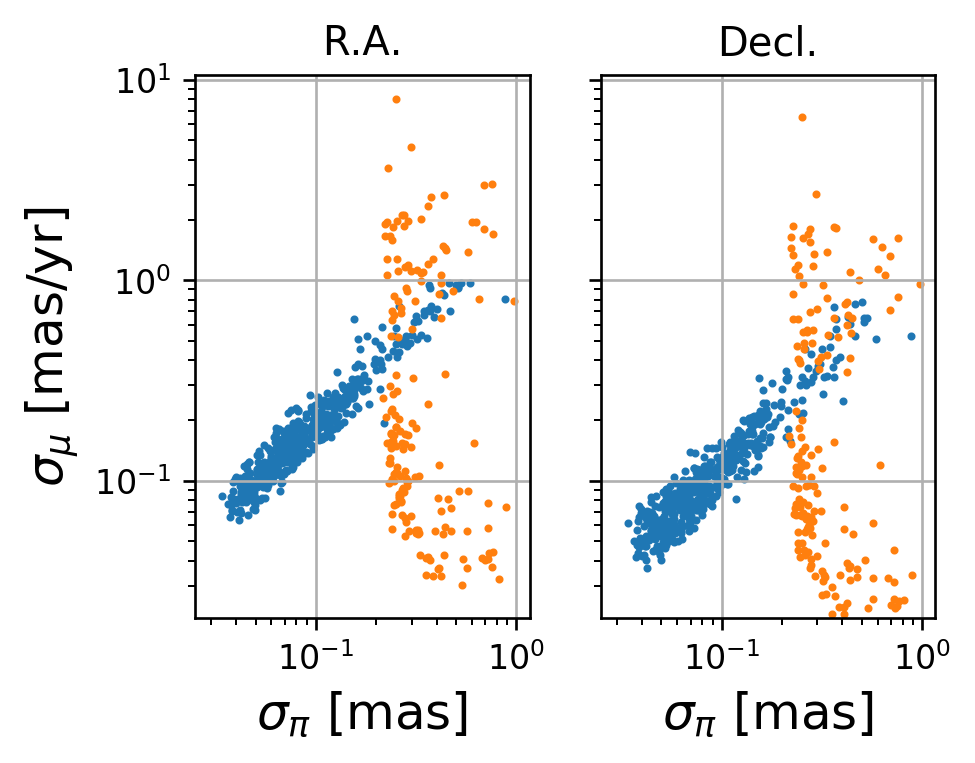

In [182]:
fig, ax = plt.subplots(1, 2, figsize=(4,3), sharex=True, sharey=True)
list(map(lambda x: x.set_aspect('equal'), ax))
ax[0].scatter(hy_dr2['parallax_error'], hy_dr2['pmra_error'], s=2)
ax[0].scatter(hy_tgas['parallax_error'], hy_tgas['pmra_error'], s=2);
ax[1].scatter(hy_dr2['parallax_error'], hy_dr2['pmdec_error'], s=2)
ax[1].scatter(hy_tgas['parallax_error'], hy_tgas['pmdec_error'], s=2);
ax[0].loglog()
ax[1].loglog()

ax[0].set_xlabel(r"$\sigma_\pi$ [mas]")
ax[0].set_ylabel(r"$\sigma_\mu$ [mas/yr]")
ax[1].set_xlabel(r"$\sigma_\pi$ [mas]")
ax[0].set_title('R.A.')
ax[1].set_title('Decl.')

ax[0].grid()
ax[1].grid();

In [33]:
def calculate_vtan_error(df):
    vra_error = np.hypot(df.pmra_error/df.parallax,
                         df.parallax_error/df.parallax**2*df.pmra)*4.74
    vdec_error = np.hypot(df.pmdec_error/df.parallax,
                          df.parallax_error/df.parallax**2*df.pmdec)*4.74
    return vra_error, vdec_error

def add_vtan_errors(df):
    df = df.copy()
    vra_error, vdec_error = calculate_vtan_error(df)
    df['vra_error'] = vra_error
    df['vdec_error'] = vdec_error
    return df

def add_vtan(df):
    df = df.copy()
    vra, vdec = df.pmra/df.parallax*4.74, df.pmdec/df.parallax*4.74
    df['vra'] = vra
    df['vdec'] = vdec
    return df

hy_tgas = hy_tgas.pipe(add_vtan).pipe(add_vtan_errors)
hy_dr2 = hy_dr2.pipe(add_vtan).pipe(add_vtan_errors)

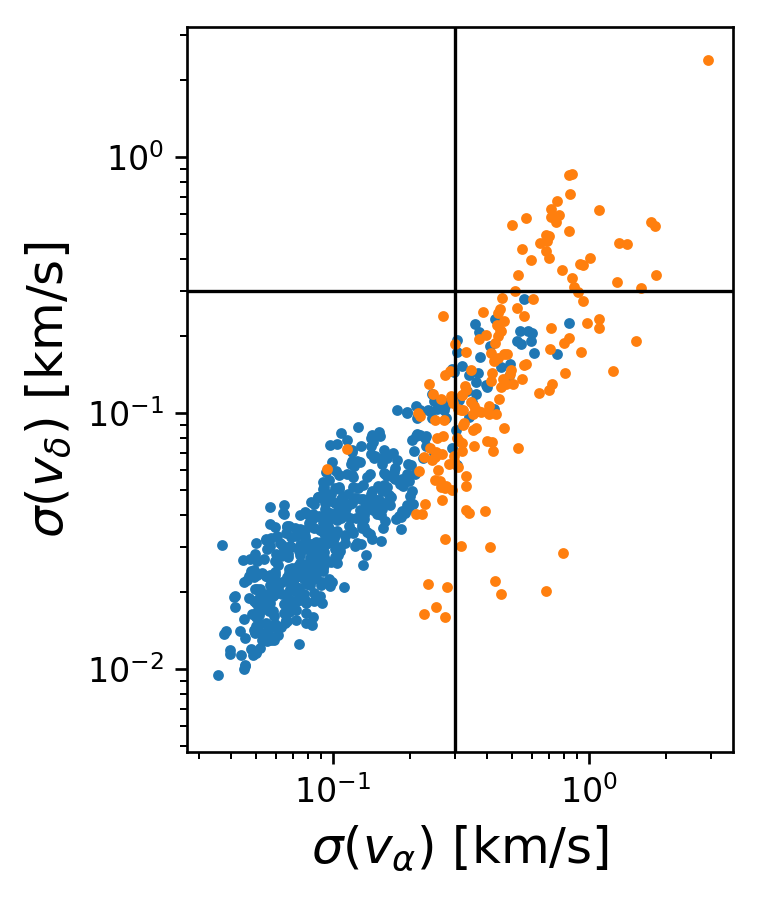

In [34]:
plt.axes(aspect='equal')
plt.scatter(hy_dr2.vra_error, hy_dr2.vdec_error, s=5)
plt.scatter(hy_tgas.vra_error, hy_tgas.vdec_error, s=5)
plt.loglog();
plt.xlabel(r"$\sigma(v_\alpha)$ [km/s]")
plt.ylabel(r"$\sigma(v_\delta)$ [km/s]");
plt.axvline(0.3, c='k', lw=1)
plt.axhline(0.3, c='k', lw=1);

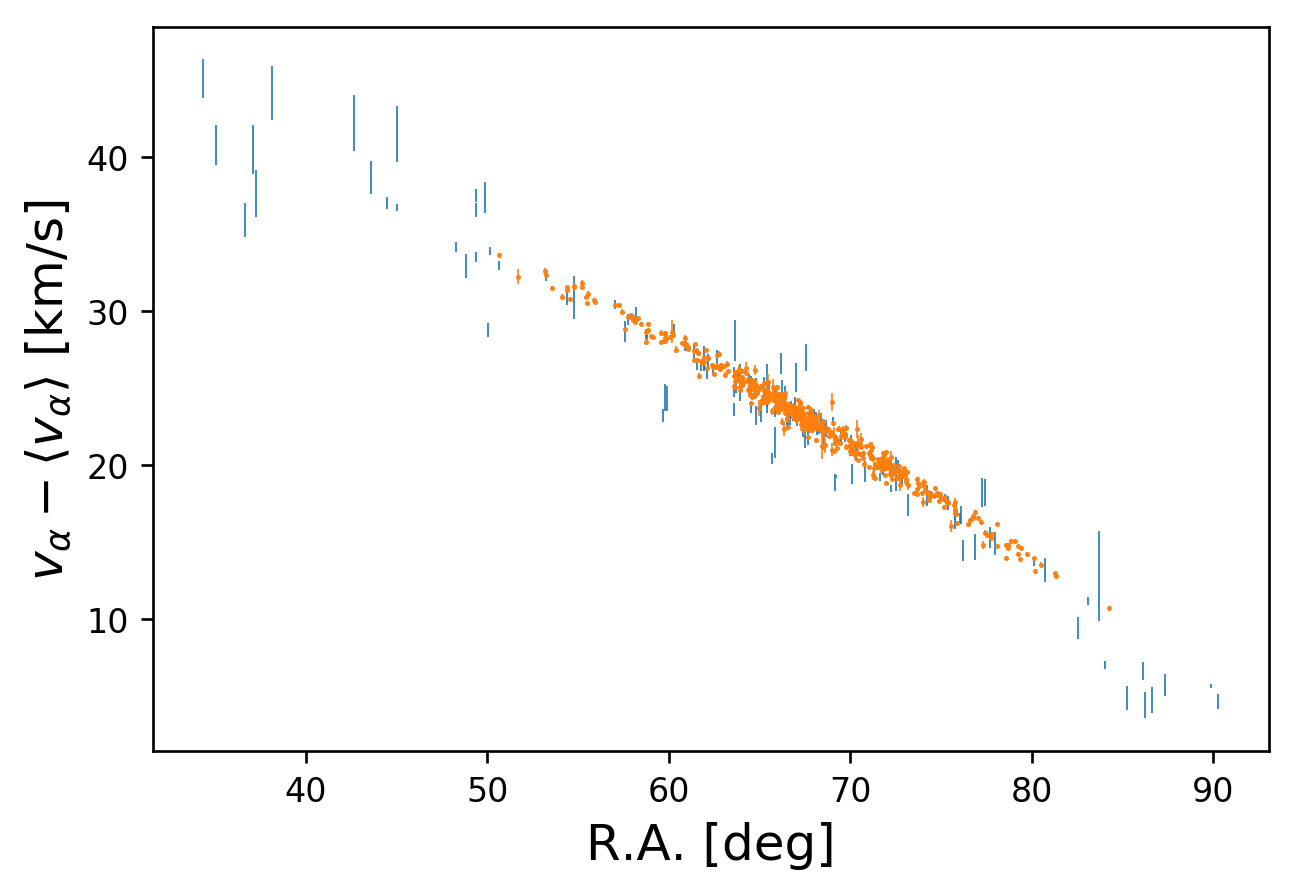

In [98]:
plt.errorbar(hy_tgas.ra, hy_tgas.vra,
             yerr=hy_tgas.vra_error, marker='None', ls='None', elinewidth=0.5)
plt.errorbar(hy_dr2.ra, hy_dr2.vra,
             yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=0.5, ls='None')
# plt.axhline(0, c='k', lw=1)
plt.xlabel("R.A. [deg]")
plt.ylabel(r"$v_\alpha - \langle v_\alpha \rangle$ [km/s]");

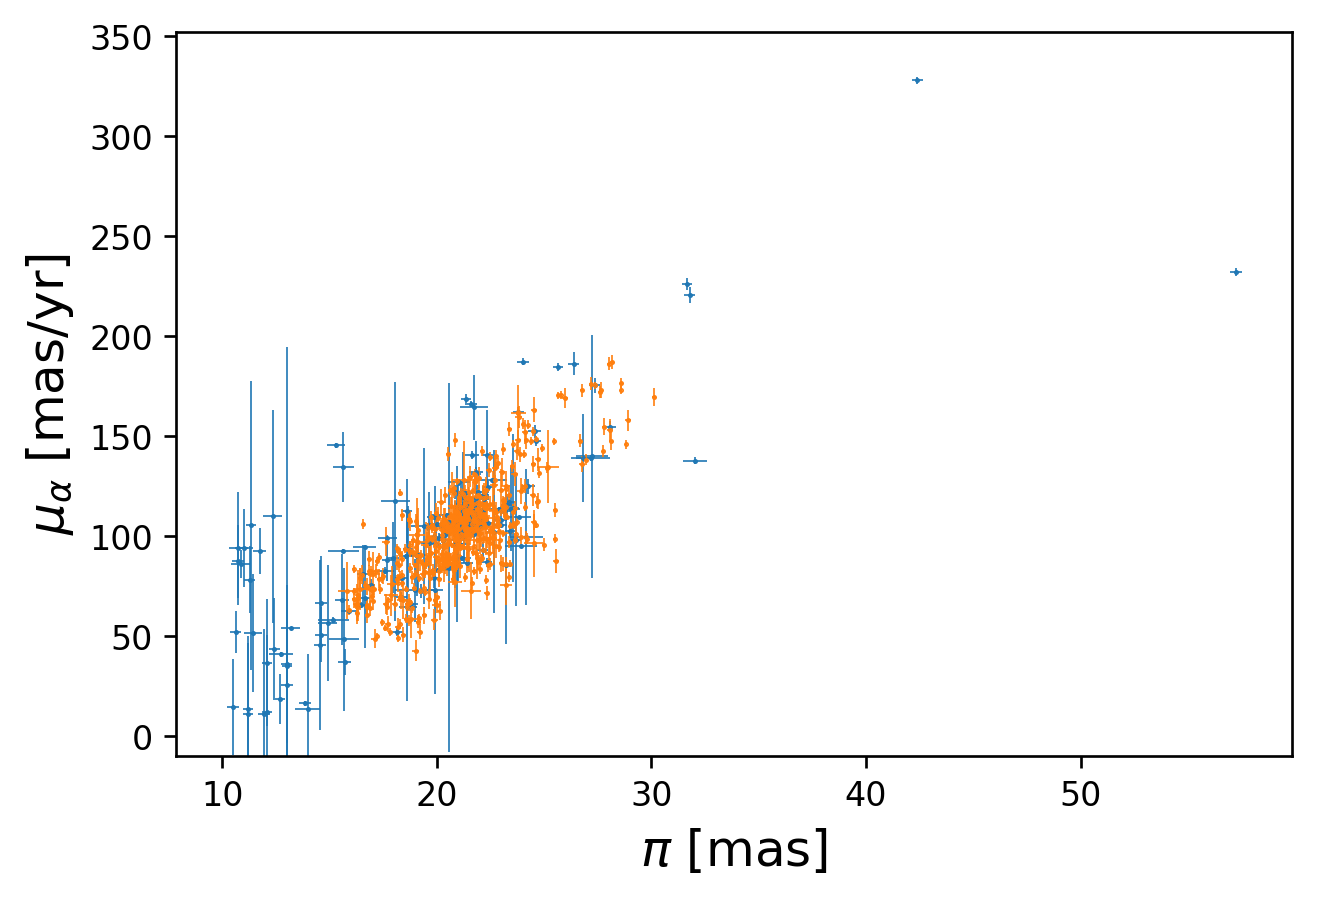

In [123]:
plt.errorbar(hy_tgas.parallax, hy_tgas.pmra,
             xerr=hy_tgas.parallax_error,
             yerr=hy_tgas.pmra_error*20, marker='.', ms=1, ls='None', elinewidth=0.5)
plt.errorbar(hy_dr2.parallax, hy_dr2.pmra,
             xerr=hy_dr2.parallax_error,
             yerr=hy_dr2.pmra_error*20, marker='.', ms=1, elinewidth=0.5, ls='None')
# plt.axhline(0, c='k', lw=1)
plt.xlabel(r"$\pi$ [mas]")
plt.ylabel(r"$\mu_\alpha$ [mas/yr]");
plt.ylim(-10,);

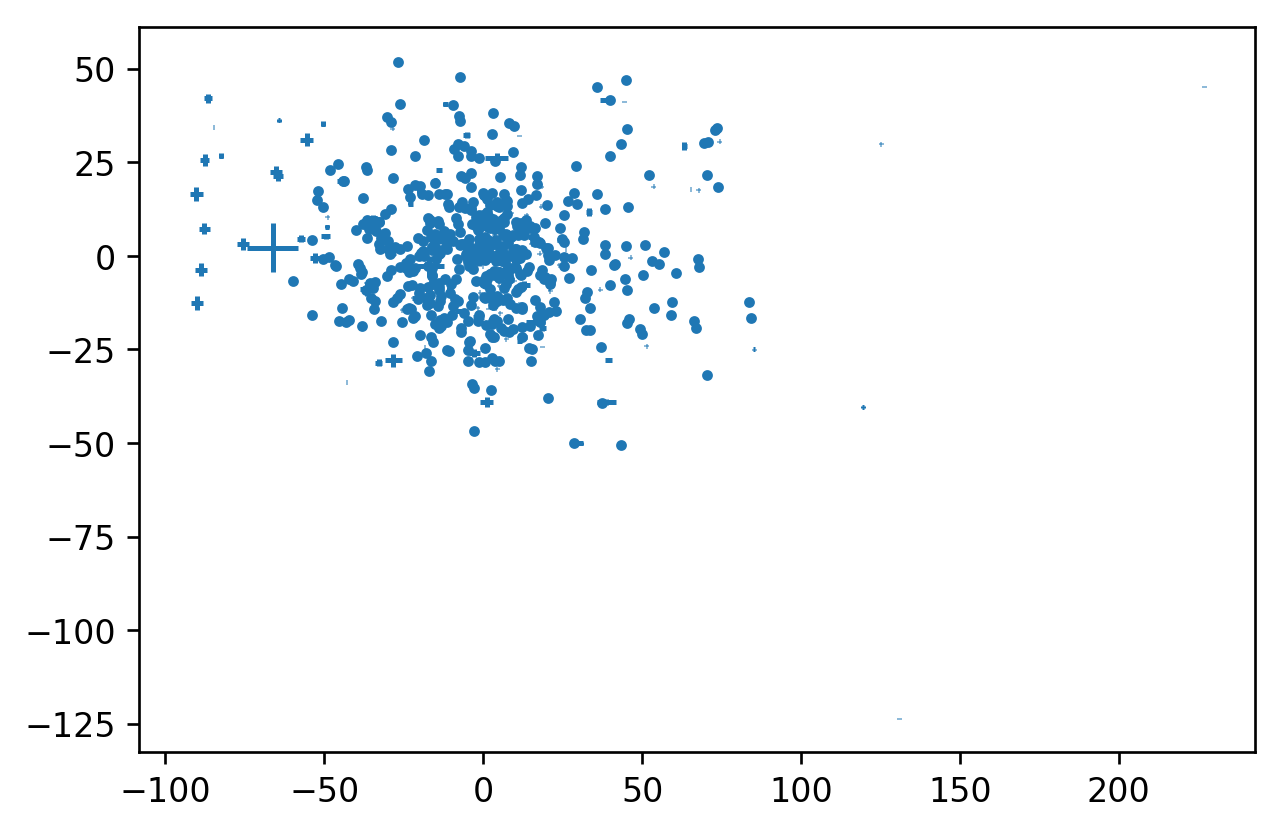

In [77]:
plt.errorbar(hy_tgas.pmra-hy_tgas.pmra.mean(), hy_tgas.pmdec-hy_tgas.pmdec.mean(),
             xerr=hy_tgas.pmra_error, yerr=hy_tgas.pmdec_error, linestyle='None')
plt.scatter(hy_dr2.pmra-hy_dr2.pmra.mean(), hy_dr2.pmdec-hy_dr2.pmdec.mean(), s=5)

In [111]:
hy_dr2_coords.cartesian.xyz.

<Quantity [[18.86473835, 21.67970908, 20.72973286, ..., 14.92250549,
            14.83928279, 14.36425723],
           [40.22548926, 37.86070217, 35.62720777, ..., 44.92937739,
            44.06390746, 43.94131827],
           [17.72885924, 14.33914541, 15.35224482, ..., 13.10431982,
            12.50247692, 12.29121248]] pc>

In [131]:
hy_dr2_copy = hy_dr2.copy()

In [144]:
hy_dr2 = hy_tgas

In [281]:
def make_icrs(df, include_pm_rv=True):
    """Make astropy coordinates from gaia_source DataFrame"""
    if not include_pm_rv:
        return coord.SkyCoord(
            ra=df.ra.values*u.deg,        
            dec=df.dec.values*u.deg,
            distance=1000./df.parallax.values*u.pc)
    return coord.SkyCoord(
            ra=df.ra.values*u.deg,        
            dec=df.dec.values*u.deg,
            distance=1000./df.parallax.values*u.pc,
            pm_ra_cosdec=df.pmra.values*u.mas/u.year,
            pm_dec=df.pmdec.values*u.mas/u.year,
            radial_velocity=df.radial_velocity.values*u.km/u.s)

def project_mean_velocity(vmean, position):
    """
    Project vmean at `position` and get predicted proper motions
    
    vmean : quantity (v_x, v_y, v_z)
        in cartesian equatorial coordinates, km/s
    position :
    
    Returns (pmra, pmdec) in units of mas/yr
    """
    if isinstance(position, pd.DataFrame):
        icrs = make_icrs(position, include_pm_rv=False)
    cartesian_coords = coord.ICRS(
        icrs.cartesian.xyz,
        v_x=[vmean[0]]*len(icrs),
        v_y=[vmean[1]]*len(icrs),
        v_z=[vmean[2]]*len(icrs),
        representation_type='cartesian',
        differential_type='cartesian')
    pmra = cartesian_coords.spherical.differentials['s'].d_lon.to(u.mas/u.yr).value
    pmdec = cartesian_coords.spherical.differentials['s'].d_lat.to(u.mas/u.yr).value
    rv = cartesian_coords.spherical.differentials['s'].d_distance.to(u.km/u.s).value
    return pmra, pmdec, rv

vmean = [-5.96, 45.60, 5.57] * u.km/u.s   # cartesian equatorial
pmra0_dr2, pmdec0_dr2, rv0_dr2 = project_mean_velocity(vmean, hy_dr2)
pmra0_tgas, pmdec0_tgas, rv0_tgas = project_mean_velocity(vmean, hy_tgas)

In [282]:
hy_dr2_coords = coord.ICRS(
    hy_dr2.ra.values*u.deg, hy_dr2.dec.values*u.deg, 1e3*u.pc/hy_dr2.parallax.values,
    pm_ra_cosdec=hy_dr2.pmra.values*u.mas/u.yr, pm_dec = hy_dr2.pmdec.values*u.mas/u.yr)
hy_tgas_coords = coord.ICRS(
    hy_tgas.ra.values*u.deg, hy_tgas.dec.values*u.deg, 1e3*u.pc/hy_tgas.parallax.values,
    pm_ra_cosdec=hy_tgas.pmra.values*u.mas/u.yr, pm_dec = hy_tgas.pmdec.values*u.mas/u.yr)

hy_dr2_coords_mean = coord.ICRS(
    hy_dr2_coords.cartesian.xyz,
    v_x=[vmean[0]]*len(hy_dr2_coords),
    v_y=[vmean[1]]*len(hy_dr2_coords),
    v_z=[vmean[2]]*len(hy_dr2_coords),
    representation_type='cartesian',
    differential_type='cartesian').spherical

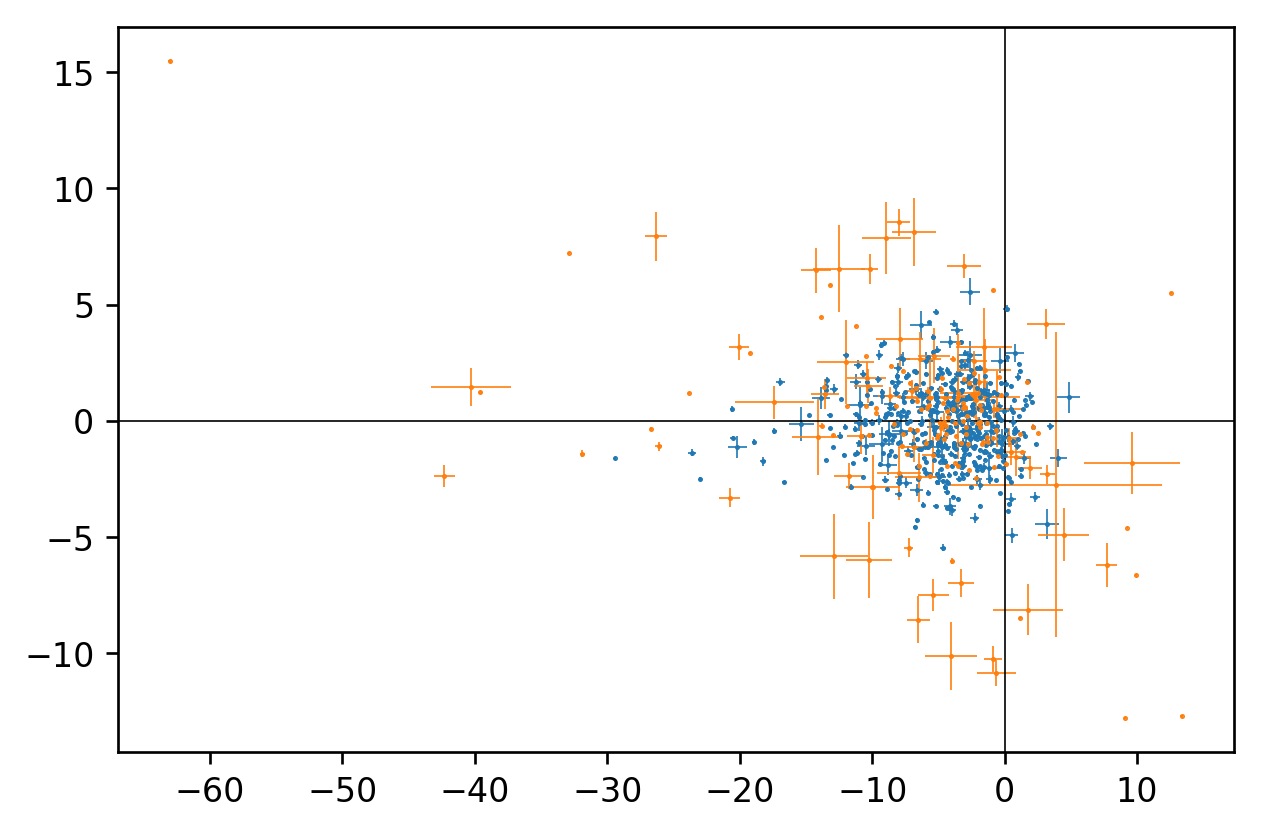

In [283]:
# fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
fig, ax = plt.subplots(1, 1,)
plt.errorbar(
    hy_dr2.pmra-pmra0_dr2,
    hy_dr2.pmdec-pmdec0_dr2,
    ls='None',
    xerr=hy_dr2.pmra_error, yerr=hy_dr2.pmdec_error, marker='.', ms=1, elinewidth=.5);
plt.errorbar(
    hy_tgas.pmra-pmra0_tgas,
    hy_tgas.pmdec-pmdec0_tgas,
    ls='None',
    xerr=hy_tgas.pmra_error, yerr=hy_tgas.pmdec_error, marker='.', ms=1, elinewidth=.5);
plt.axhline(0, c='k', lw=.5)
plt.axvline(0, c='k', lw=.5);

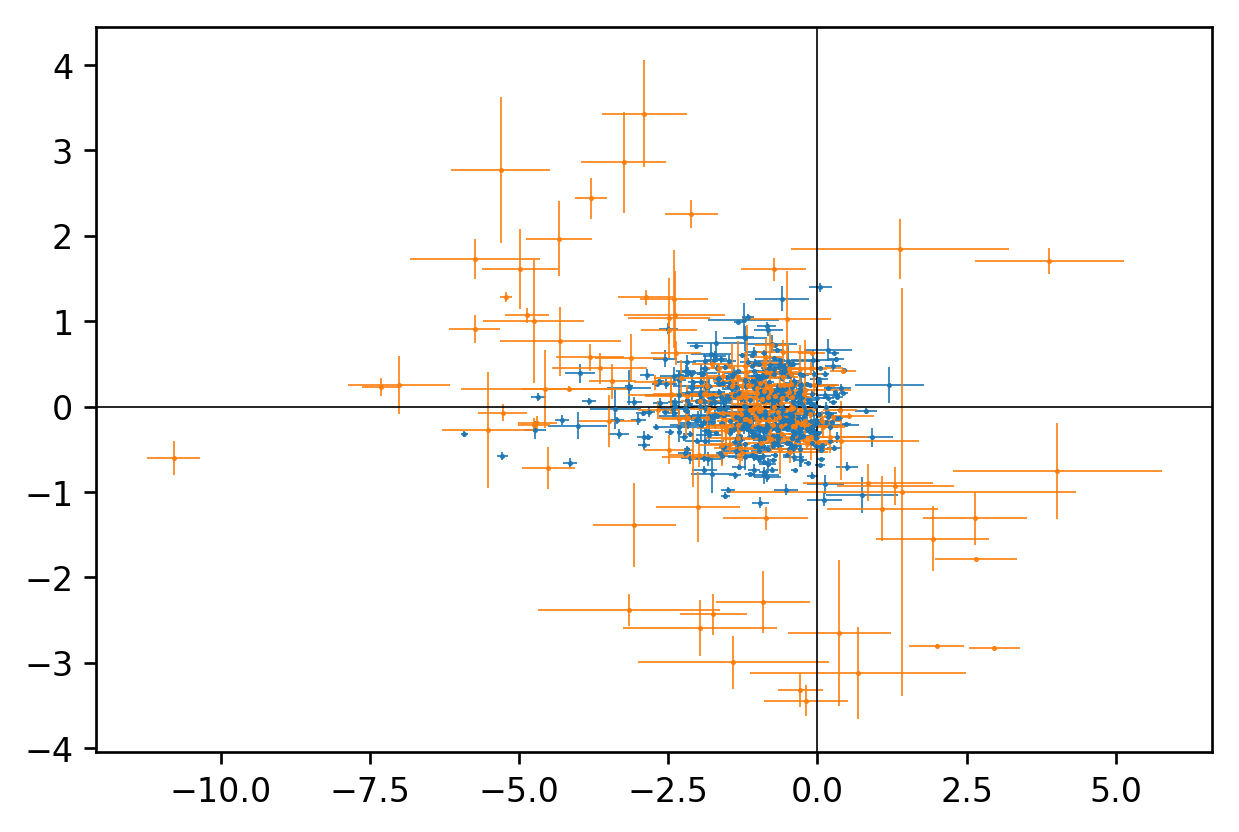

In [284]:
# fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
fig, ax = plt.subplots(1, 1,)
plt.errorbar(
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    xerr=hy_dr2.vra_error, yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);

plt.errorbar(
    (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
    (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

plt.axhline(0, c='k', lw=.5)
plt.axvline(0, c='k', lw=.5);

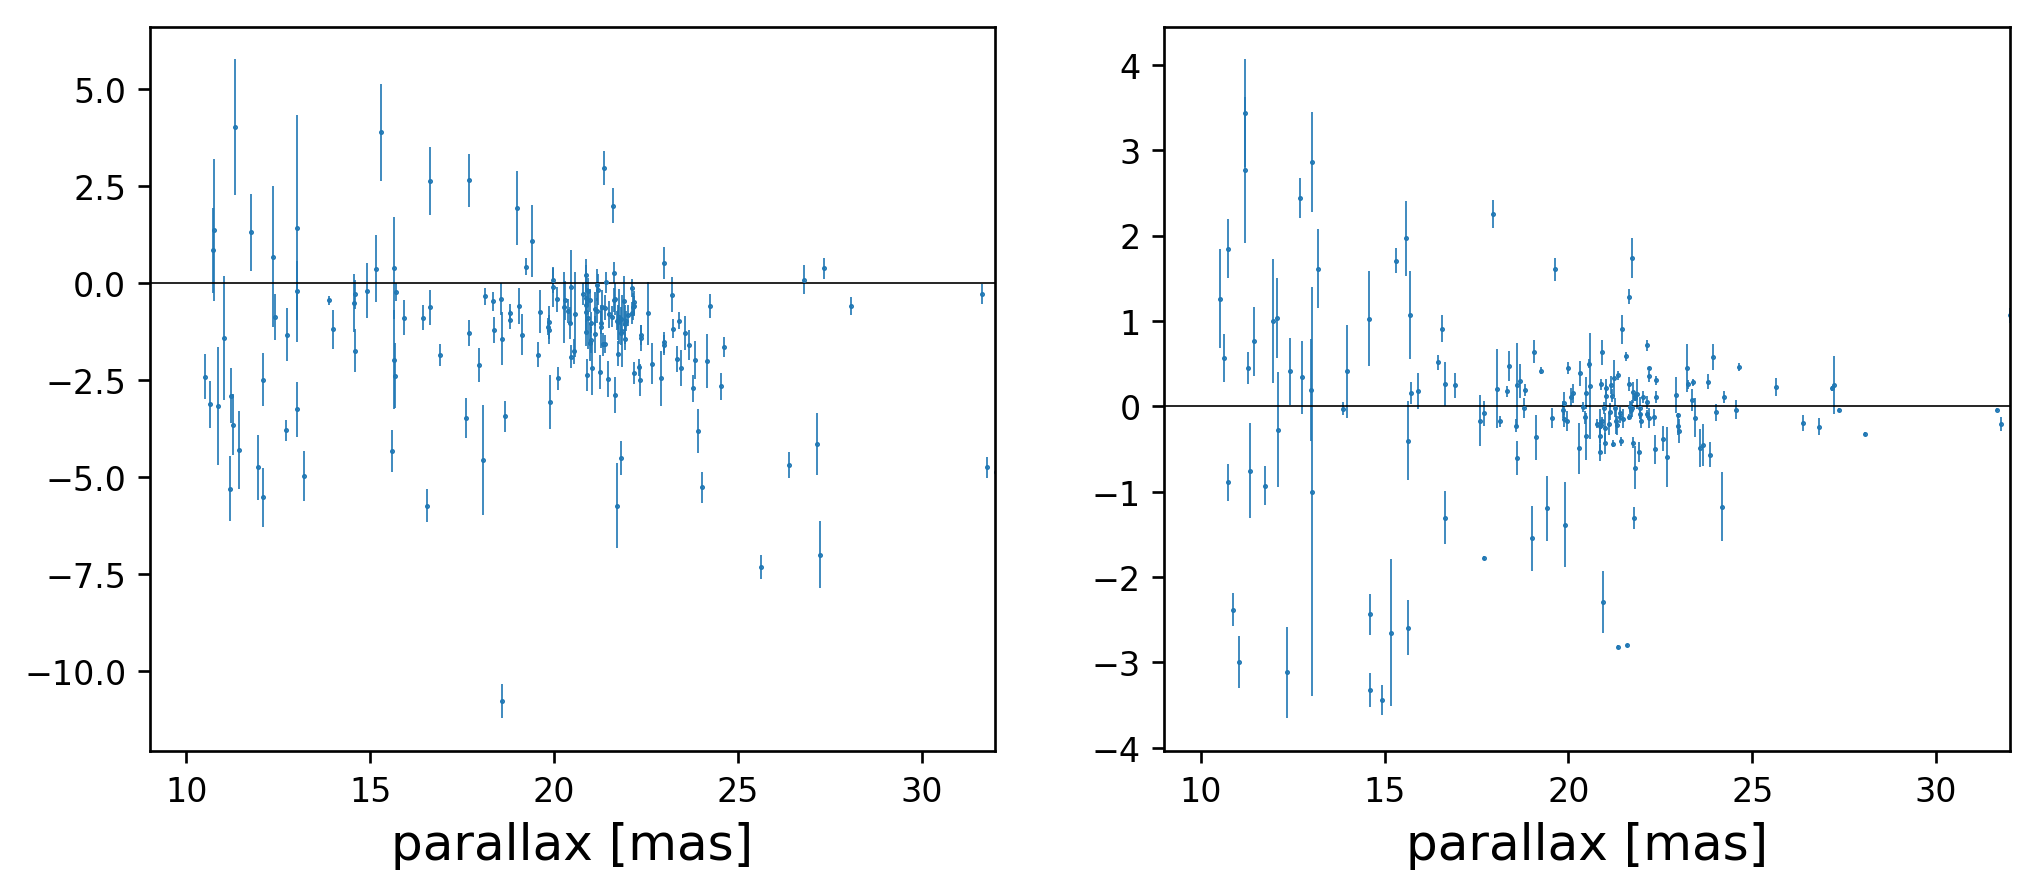

In [285]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True)

# ax[0].errorbar(
#     hy_dr2.parallax,
#     (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
#     ls='None',
#     yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
# ax[1].errorbar(
#     hy_dr2.parallax,
#     (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
#     ls='None',
#     yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);


ax[0].errorbar(
    hy_tgas.parallax,
    (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_tgas.parallax,
    (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);
# plt.errorbar(
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.axhline(0, c='k', lw=.5)
# plt.axvline(0, c='k', lw=.5);

ax[0].set_xlim(9,32)
ax[1].set_xlim(9,32);
ax[0].axhline(0, c='k', lw=.5)
ax[1].axhline(0, c='k', lw=.5)

ax[0].set_xlabel('parallax [mas]')
ax[1].set_xlabel('parallax [mas]');

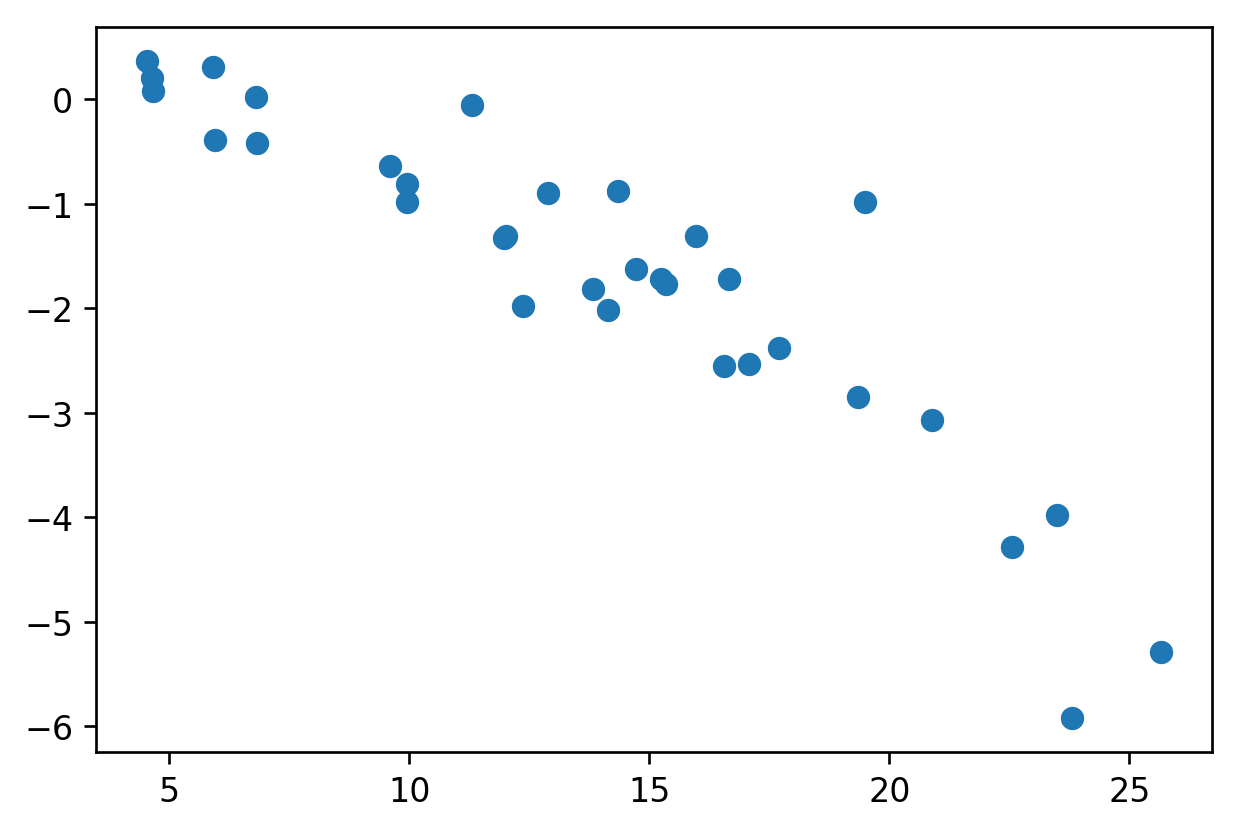

In [315]:
slc = np.fabs(   np.sin(np.deg2rad(hy_dr2.ra))-0.85)<0.02
plt.scatter(
    hy_dr2_coords.cartesian.z.value[slc],
    ((hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74)[slc], );

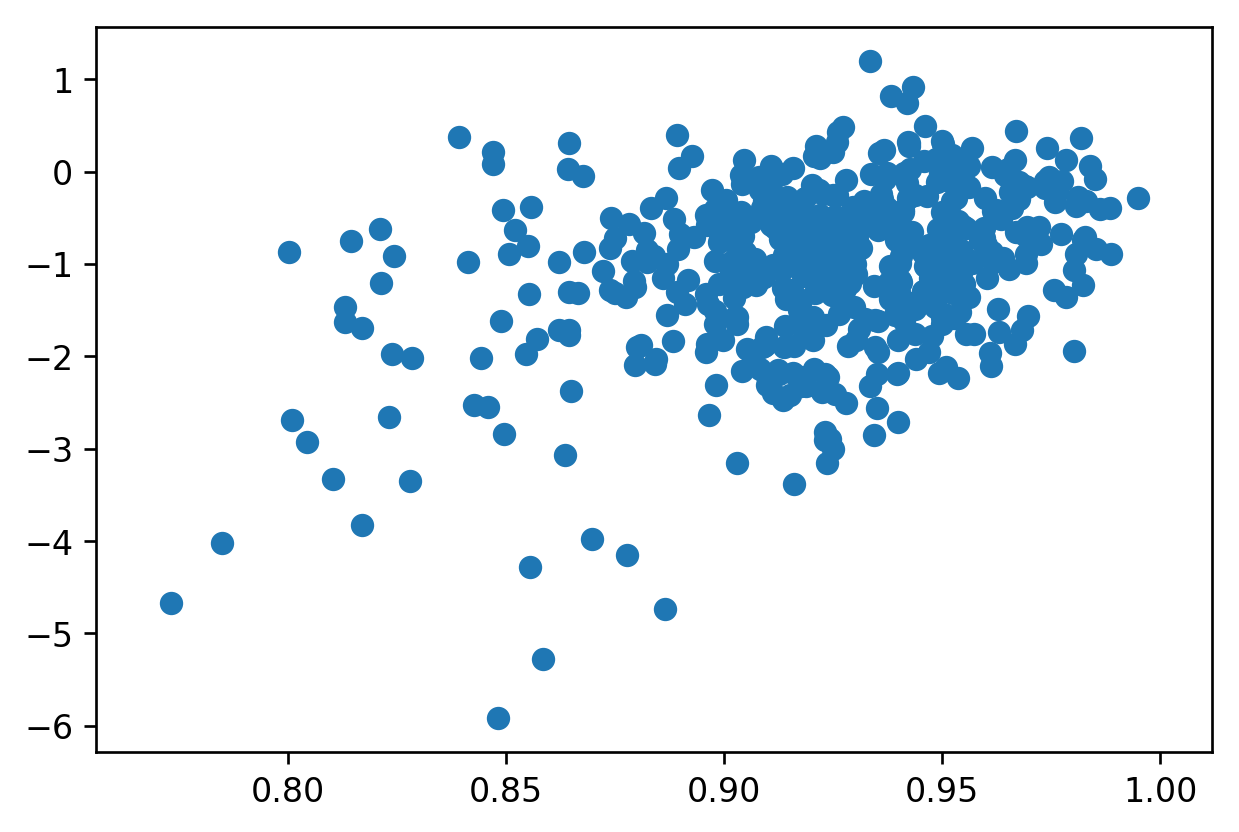

In [311]:
plt.scatter(
    np.sin(np.deg2rad(hy_dr2.ra)),
#     hy_dr2_coords.cartesian.z.value,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74, );

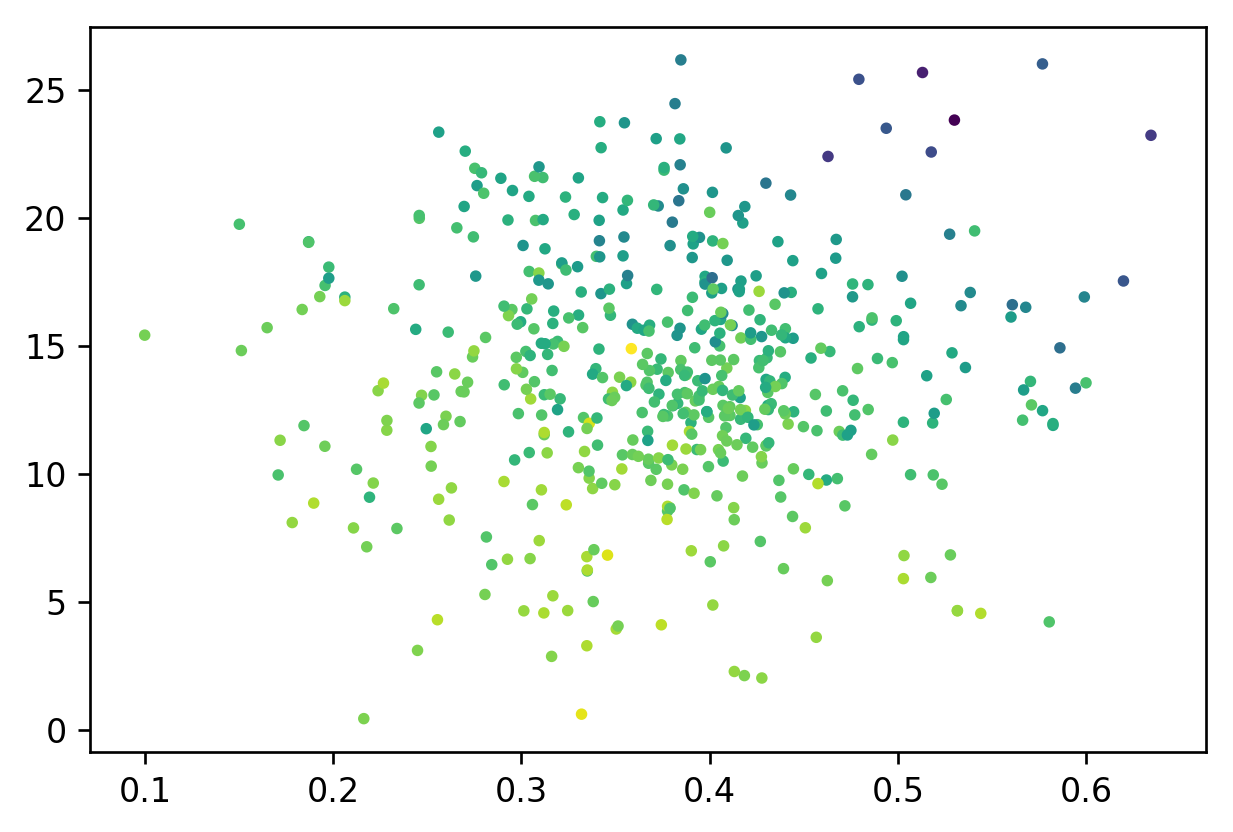

In [307]:
plt.scatter(
    np.cos(np.deg2rad(hy_dr2.ra)),
    hy_dr2_coords.cartesian.z.value,
    c=(hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74, s=6);

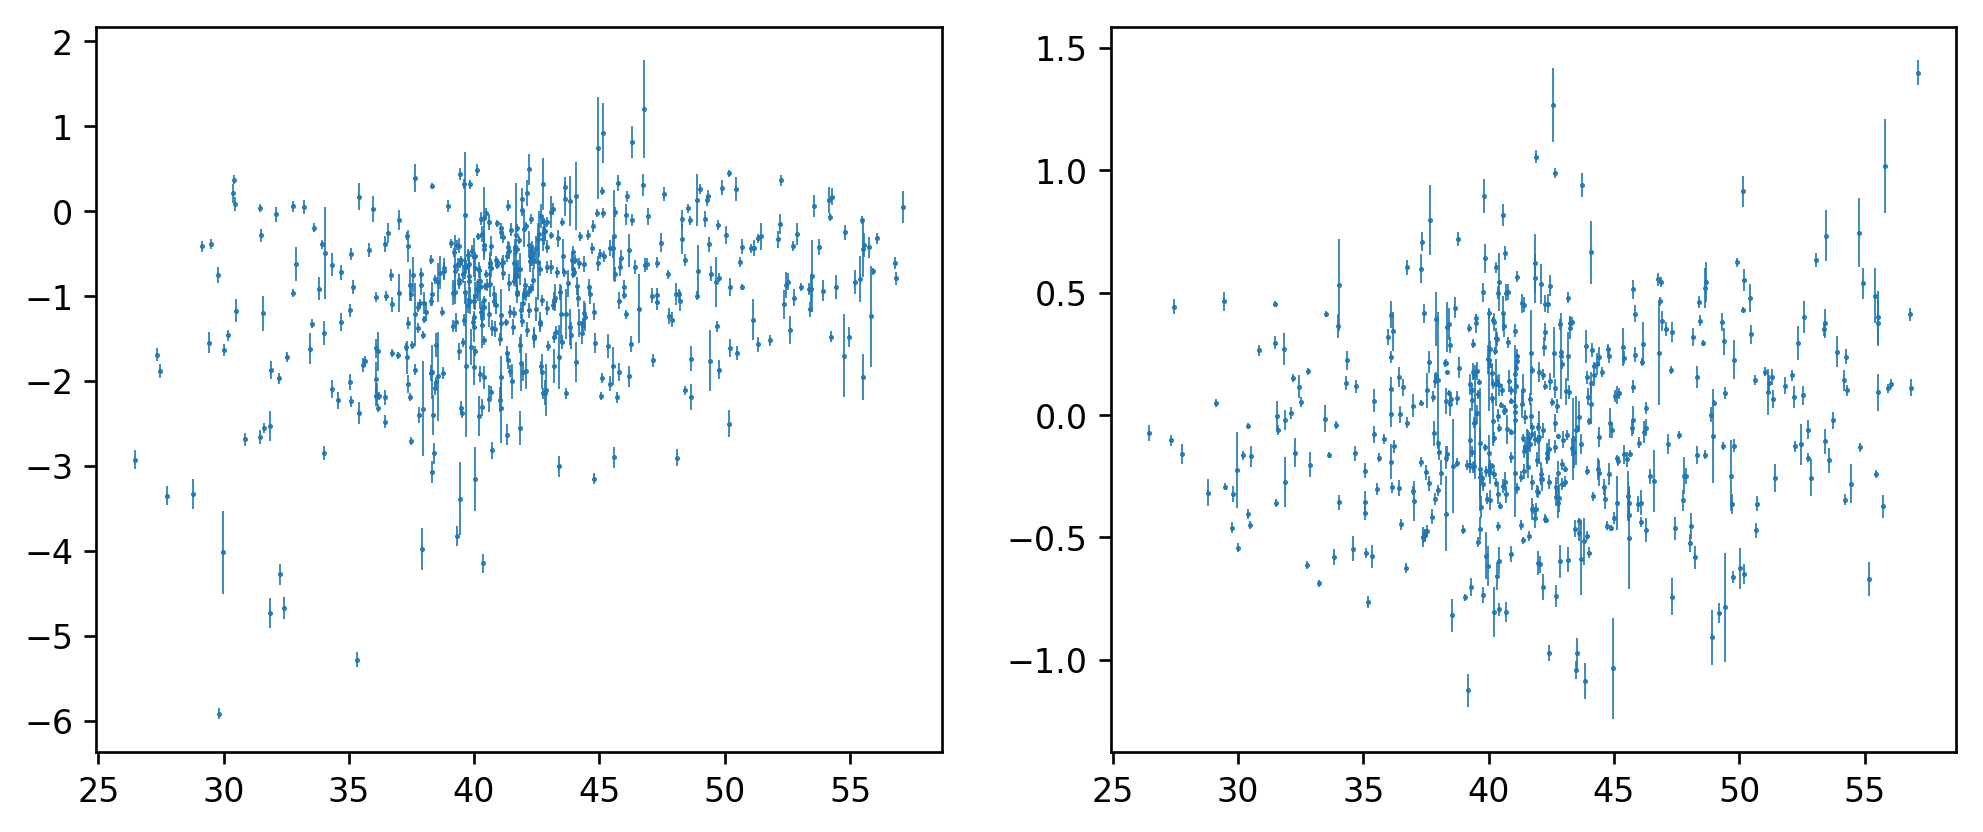

In [299]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True)

ax[0].errorbar(
    hy_dr2_coords.cartesian.y.value,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_dr2_coords.cartesian.y.value,
    (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.errorbar(
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.axhline(0, c='k', lw=.5)
# plt.axvline(0, c='k', lw=.5);

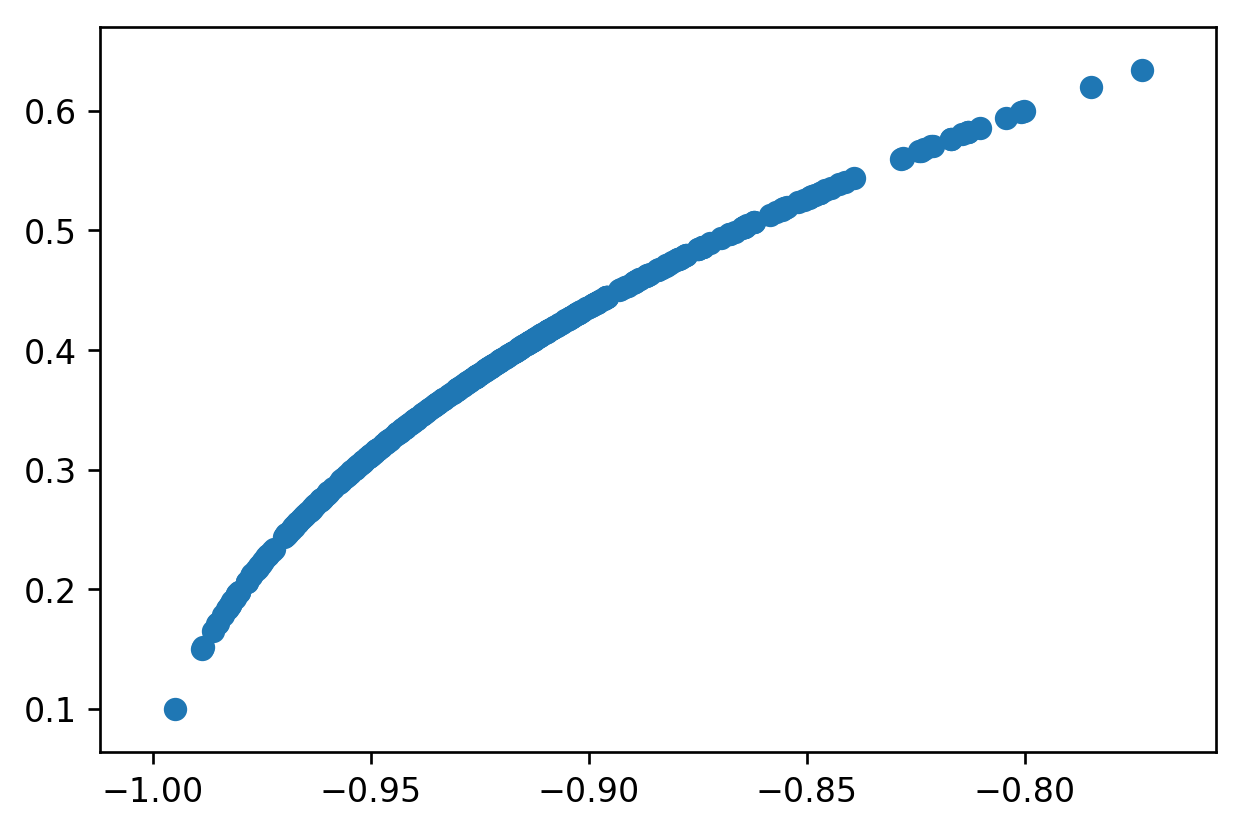

In [301]:
plt.scatter(-np.sin(np.deg2rad(hy_dr2.ra)), np.cos(np.deg2rad(hy_dr2.ra)), );

In [298]:
np.corrcoef(hy_dr2_coords.cartesian.x.value,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,)

array([[ 1.        , -0.23902276],
       [-0.23902276,  1.        ]])

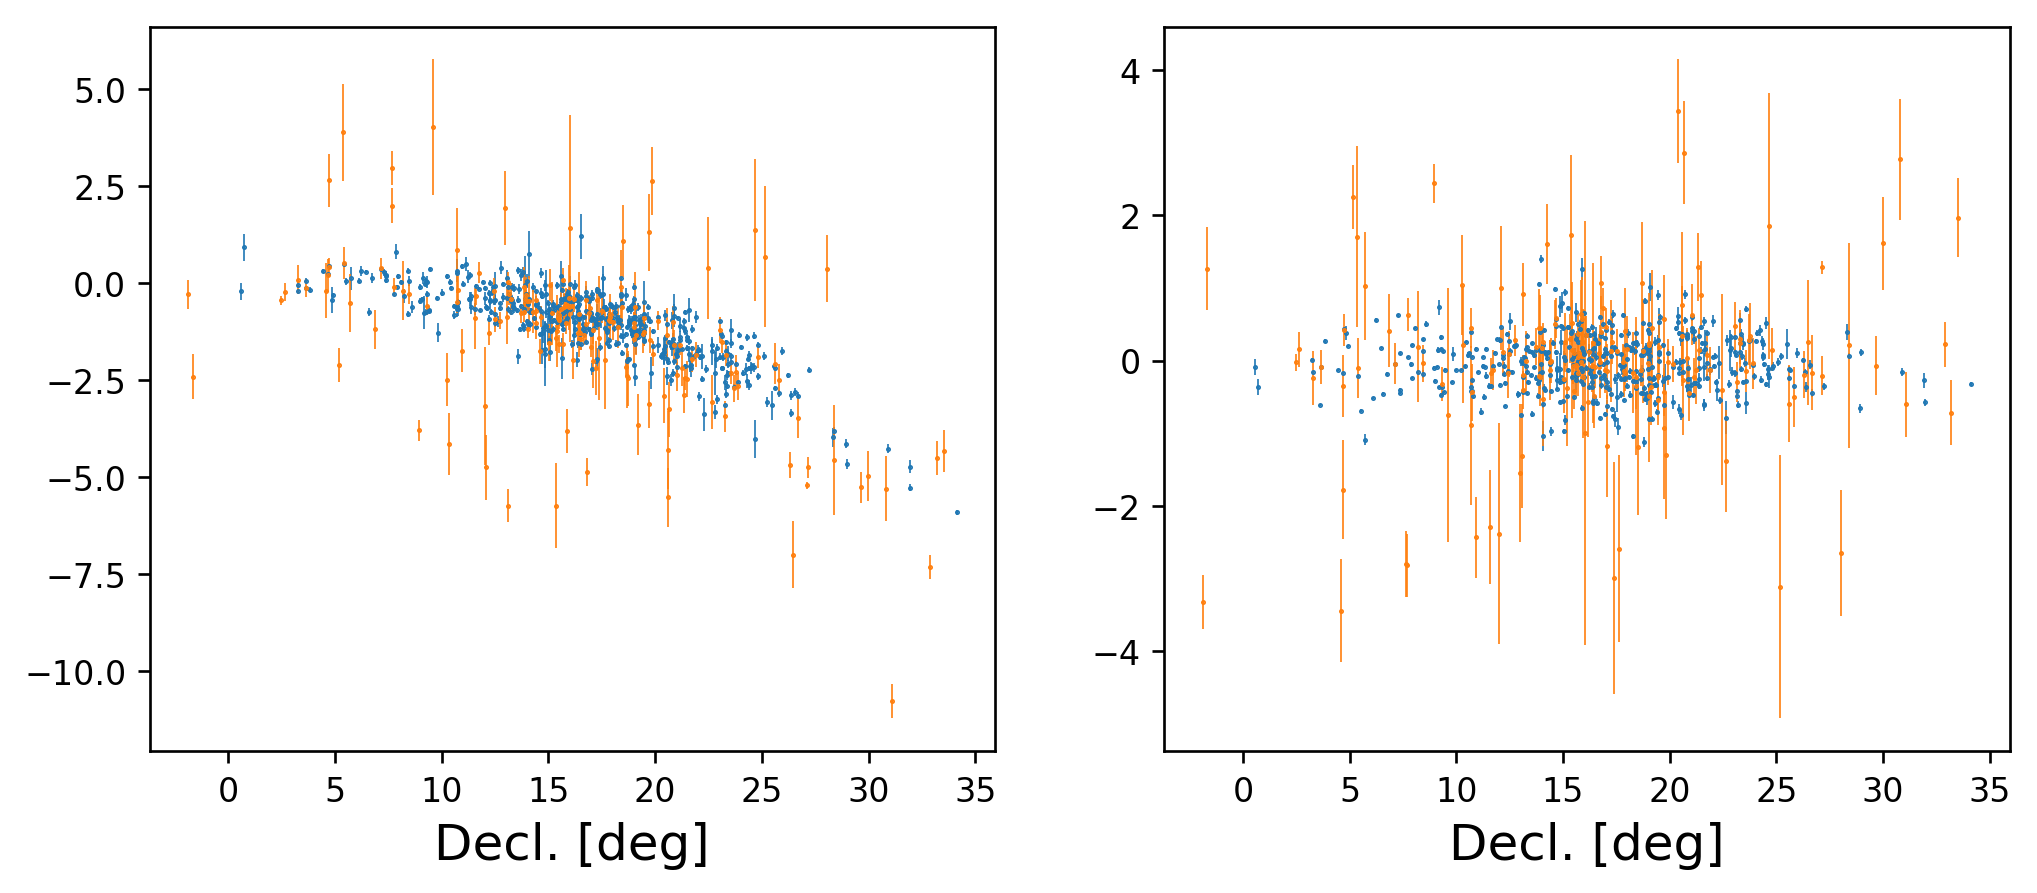

In [289]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True)

ax[0].errorbar(
    hy_dr2.dec,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_dr2.dec,
    (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);



ax[0].errorbar(
    hy_tgas.dec,
    (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_tgas.dec,
    (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
# plt.errorbar(
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.axhline(0, c='k', lw=.5)
# plt.axvline(0, c='k', lw=.5);

ax[0].set_xlabel('Decl. [deg]')
ax[1].set_xlabel('Decl. [deg]');

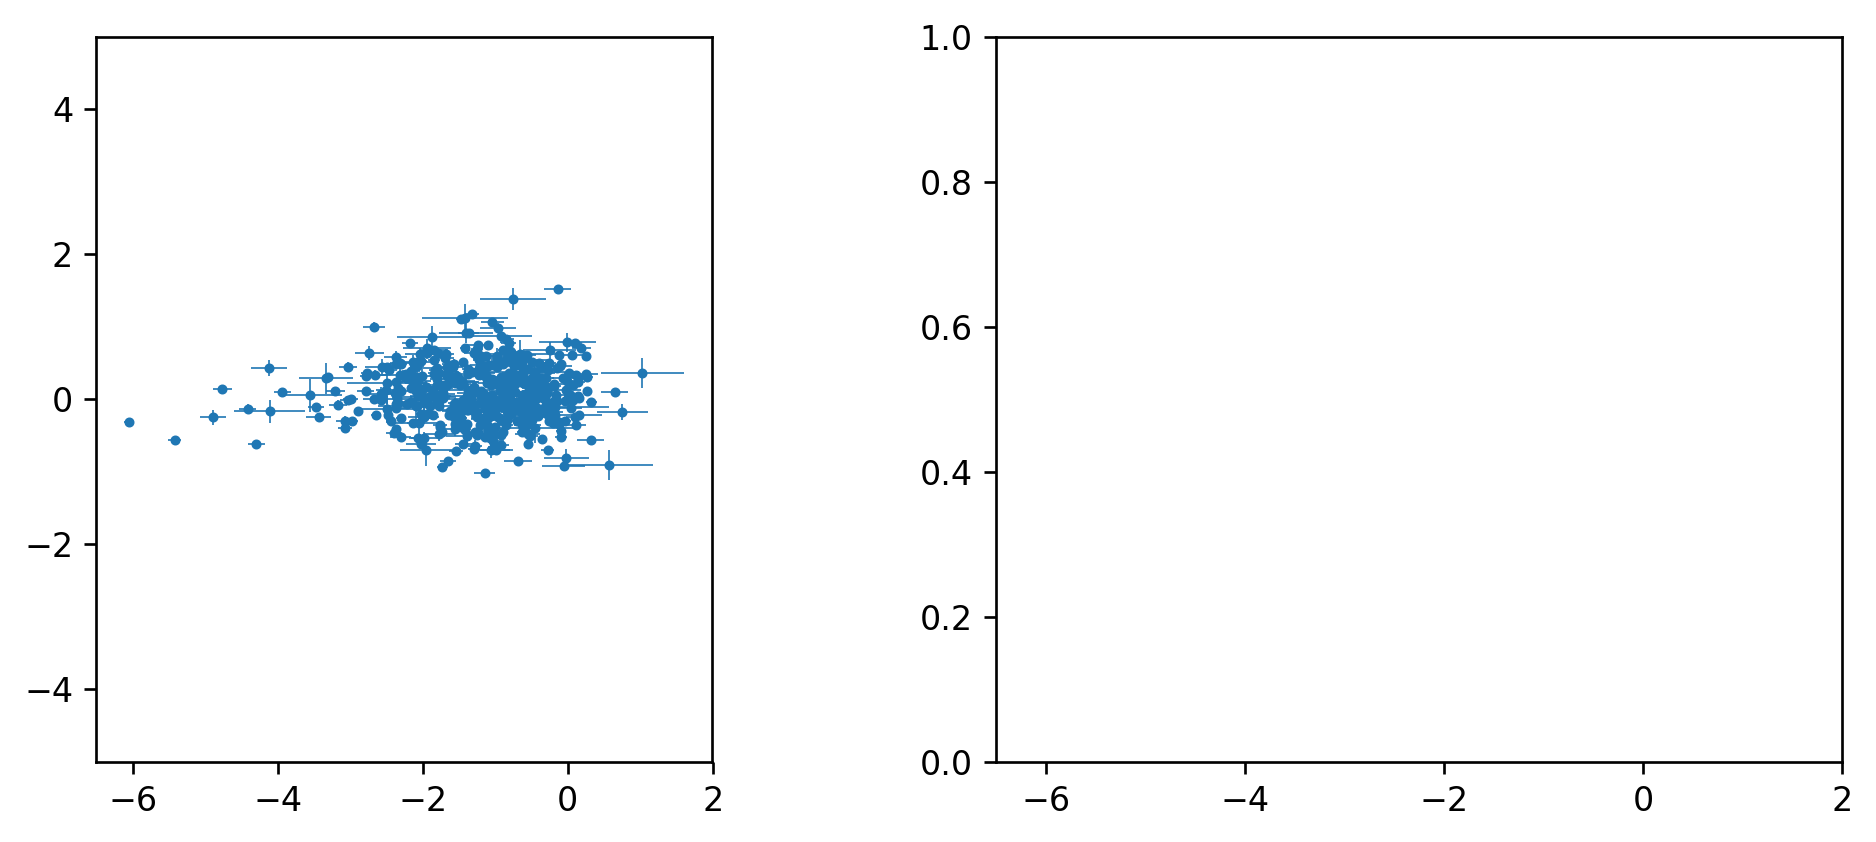

In [265]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True)

ax[0].errorbar(
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
#     (hy_dr2.radial_velocity-rv0_dr2),
    ls='None', xerr=hy_dr2.vra_error,
    yerr=hy_dr2.vdec_error, marker='.', ms=4, elinewidth=.5);
# ax[1].errorbar(
#     hy_dr2_coords.cartesian.x.value,
#     (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
#     ls='None',
#     yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);
ax[0].set_ylim(-5,5)
ax[0].set_aspect('equal')

# ax[0].errorbar(
#     hy_tgas_coords.cartesian.x.value,
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
# ax[1].errorbar(
#     hy_tgas_coords.cartesian.x.value,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
# plt.errorbar(
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.axhline(0, c='k', lw=.5)
# plt.axvline(0, c='k', lw=.5);

In [215]:
def add_xv(df, frame, unit=u.pc):
    """
    Add cartesian coordinates x, y, z, vx, vy, vz for a given `frame`
    
    df : pd.DataFrame
        Gaia DR2 data
    frame : astropy coordinate frame
        Frame to calculate coordinates in
    
    Returns df with x, y, z, vx, vy, vz columns added.
    """
    df = df.copy()
    c = make_icrs(df).transform_to(frame)
    df['x'], df['y'], df['z'] = c.cartesian.xyz.to(u.pc).value
    df['vx'], df['vy'], df['vz'] = c.velocity.d_xyz.value
    return df
hy_dr2 = hy_dr2.pipe(add_xv, coord.Galactic)

In [216]:
aa = hy_dr2.dropna(subset=['radial_velocity'])[['x','y','z', 'vx','vy','vz']]

In [222]:
aa_res = aa[['vx','vy','vz']] - aa[['vx','vy','vz']].mean()

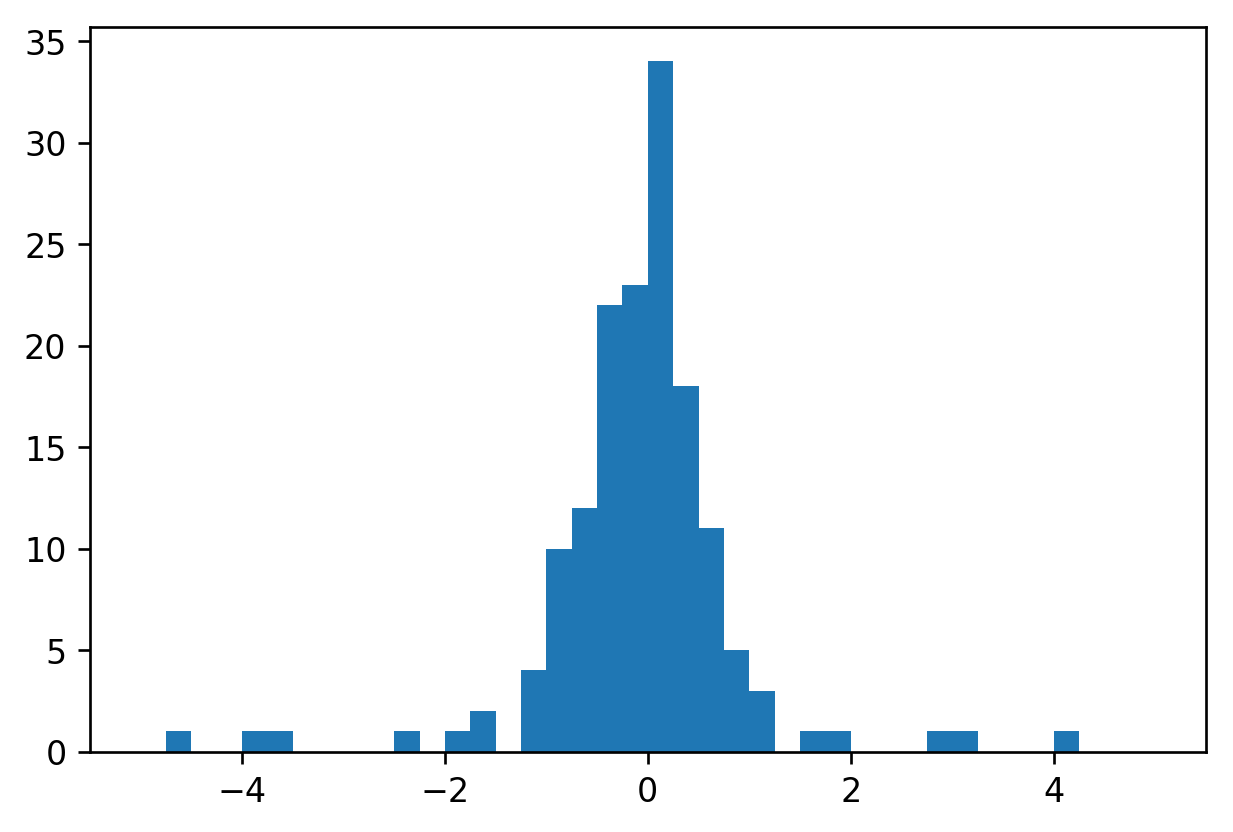

In [241]:
plt.hist(aa_res.vx-aa_res.vx.median(), bins=np.linspace(-5,5,41));

(-10, 10)

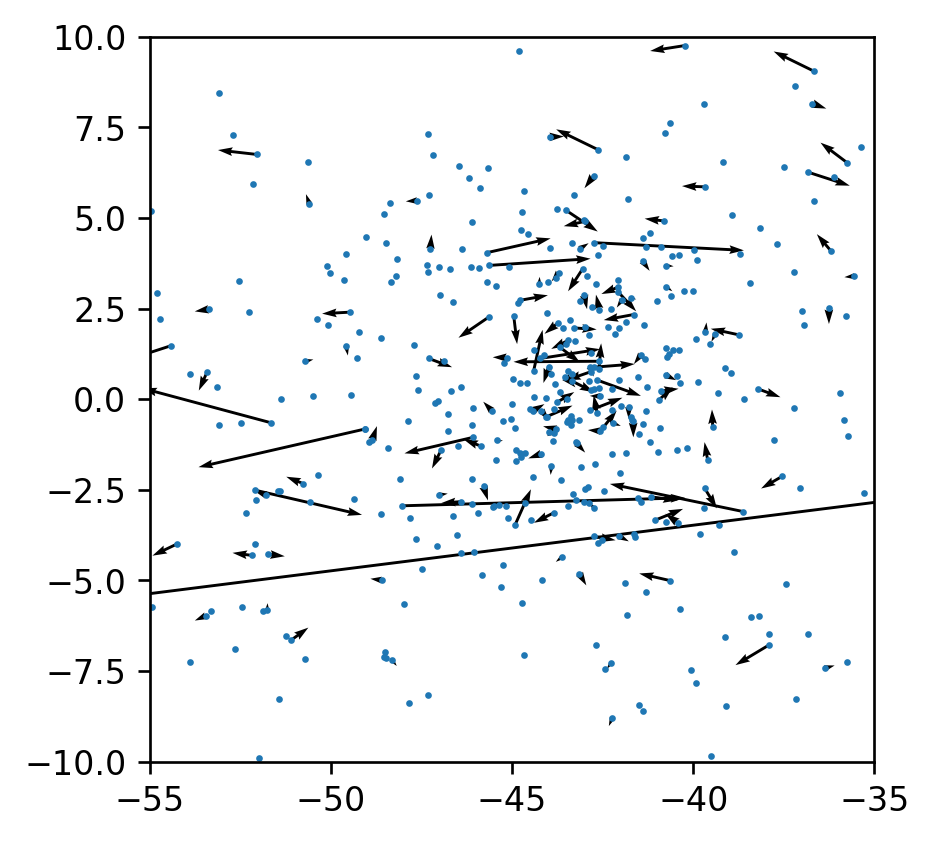

In [235]:
plt.axes(aspect='equal')
plt.quiver(aa.x, aa.y, aa_res.vx-aa_res.vx.median(), aa_res.vy, width=0.004);
plt.scatter(hy_dr2.x, hy_dr2.y, s=1);
plt.xlim(-55,-35)
plt.ylim(-10, 10)

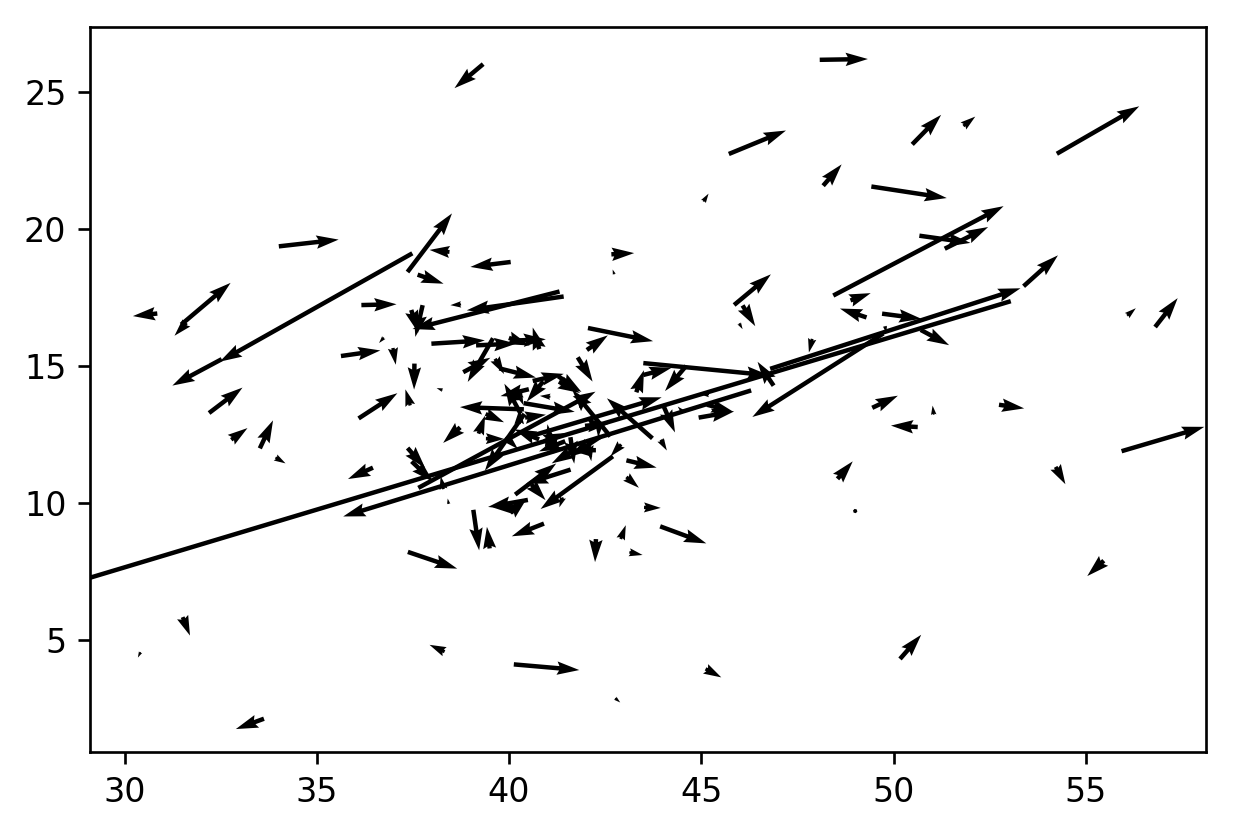

In [212]:
plt.quiver(aa.y, aa.z, aa_res.vy, aa_res.vz, width=0.004);

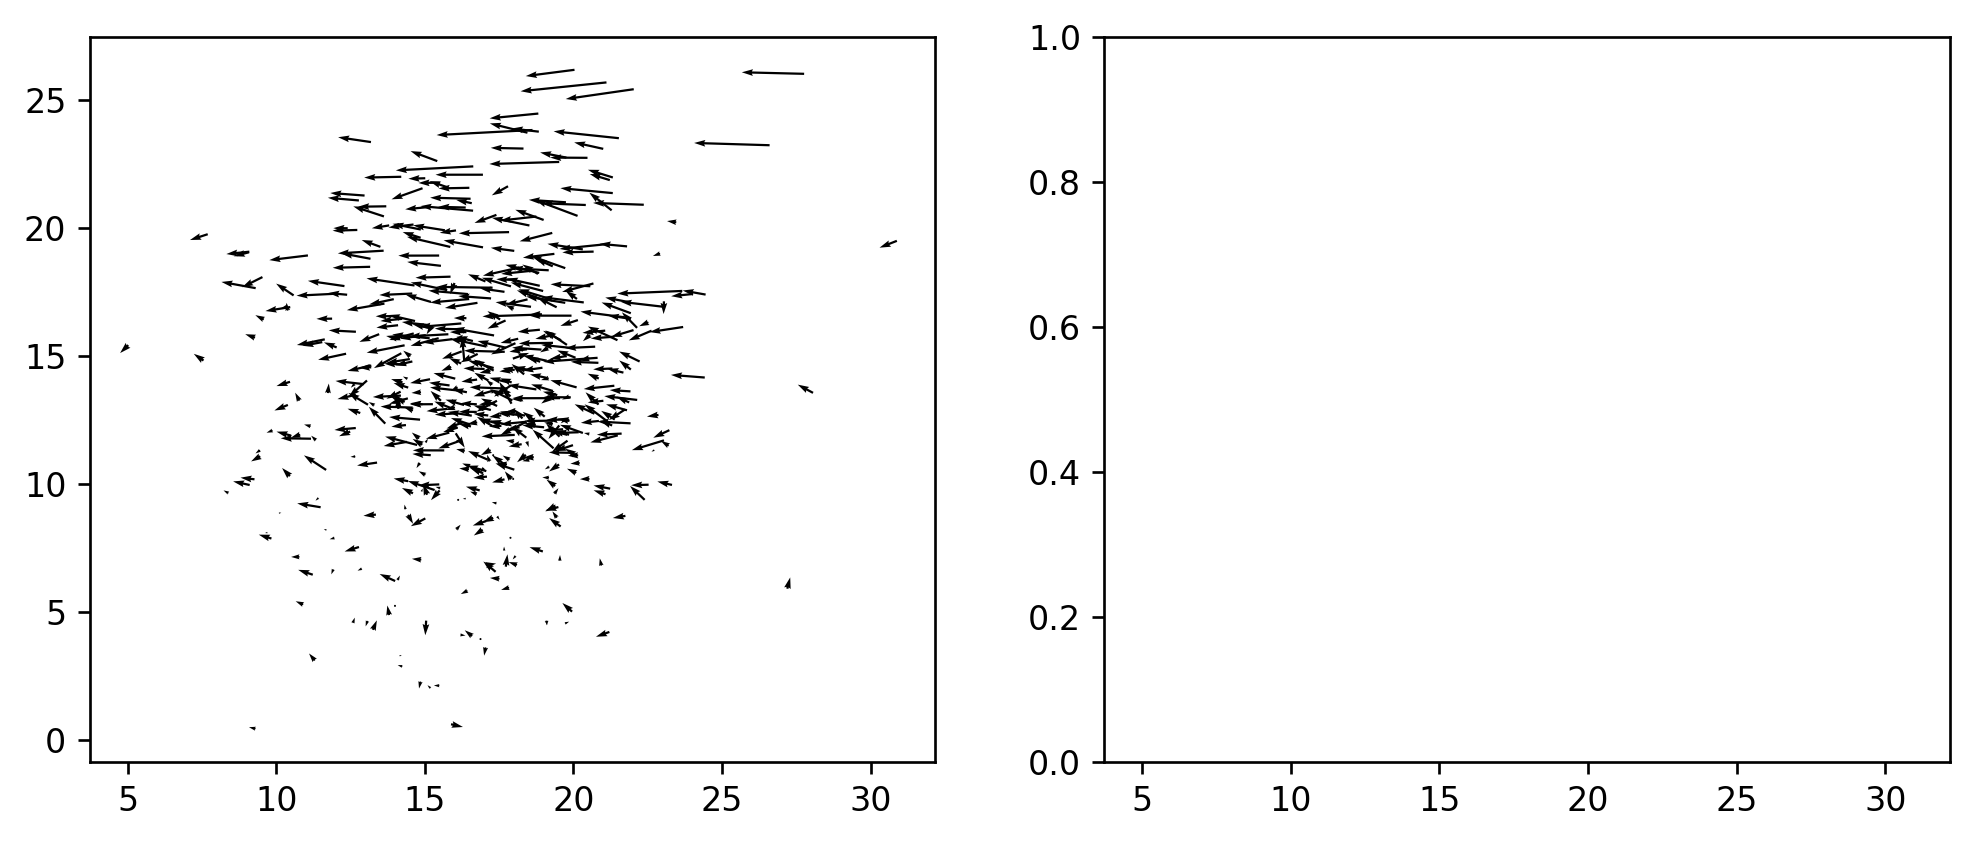

In [188]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True)

ax[0].quiver(
    hy_dr2_coords.cartesian.x.value, hy_dr2_coords.cartesian.z.value,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74, (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74
)

# ax[0].errorbar(
#     hy_dr2_coords.cartesian.x.value,
#     (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
#     ls='None',
#     yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
# ax[1].errorbar(
#     hy_dr2_coords.cartesian.x.value,
#     (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
#     ls='None',
#     yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);



# ax[0].errorbar(
#     hy_tgas_coords.cartesian.x.value,
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
# ax[1].errorbar(
#     hy_tgas_coords.cartesian.x.value,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
# plt.errorbar(
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.axhline(0, c='k', lw=.5)
# plt.axvline(0, c='k', lw=.5);

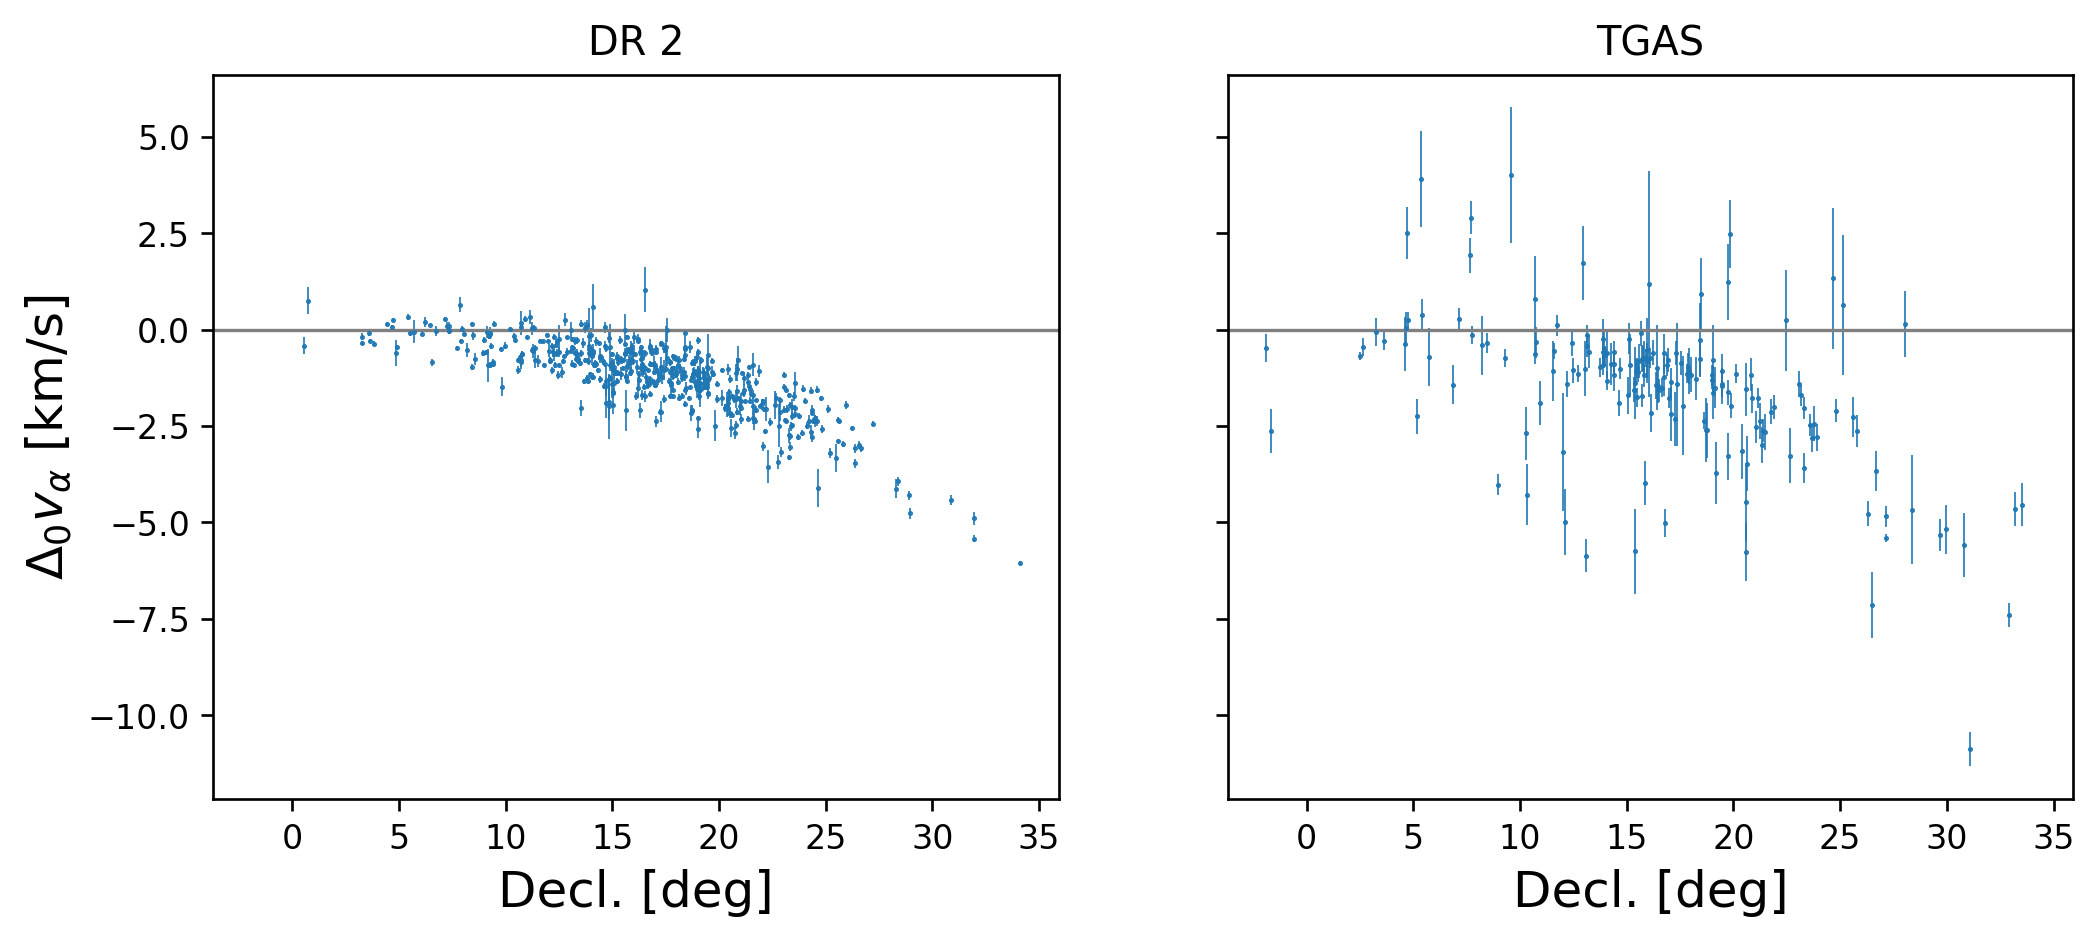

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax[0].errorbar(
    hy_dr2.dec,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_tgas.dec,
    (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);

ax[0].axhline(0, c='gray', lw=1)
ax[1].axhline(0, c='gray', lw=1)
ax[0].set_title('DR 2')
ax[1].set_title('TGAS')

ax[0].set_xlabel('Decl. [deg]')
ax[1].set_xlabel('Decl. [deg]')
ax[0].set_ylabel(r'$\Delta_0 v_\alpha$ [km/s]');

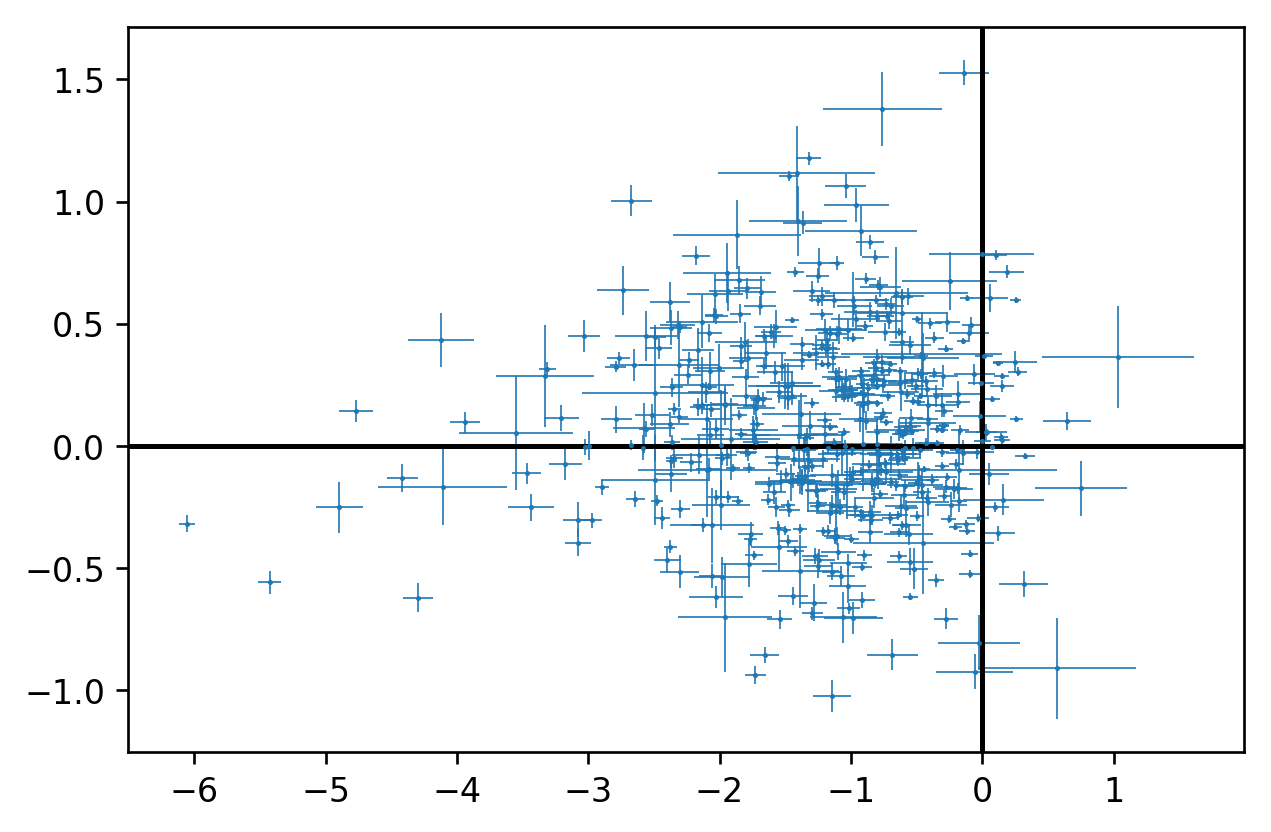

In [43]:
plt.errorbar(
    (hy_dr2.pmra-hy_dr2_coords_mean.differentials['s'].d_lon.value)/hy_dr2.parallax*4.74,
    (hy_dr2.pmdec-hy_dr2_coords_mean.differentials['s'].d_lat.value)/hy_dr2.parallax*4.74,
    ls='None',
    xerr=hy_dr2.vra_error, yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);
plt.axhline(0, c='k')
plt.axvline(0, c='k');

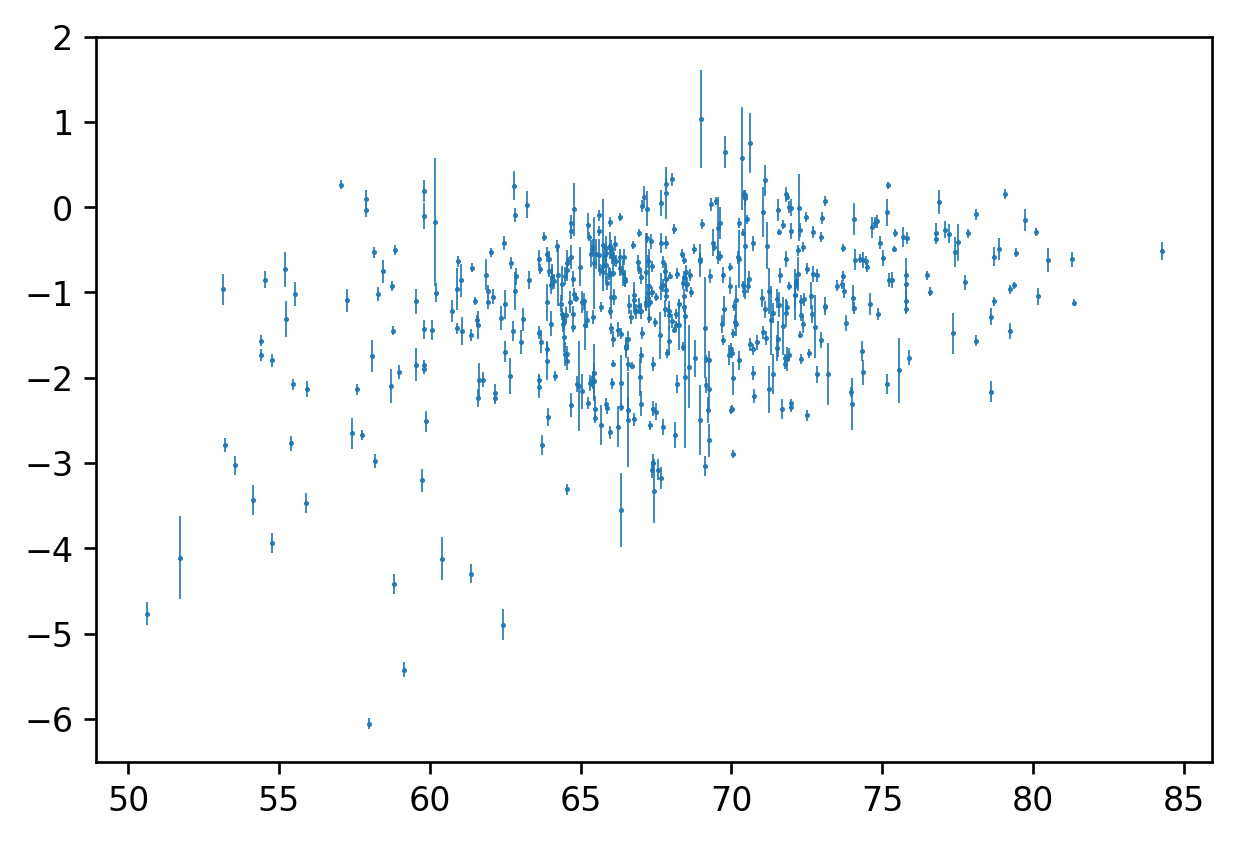

In [48]:
plt.errorbar(
    hy_dr2.ra,
    (hy_dr2.pmra-hy_dr2_coords_mean.differentials['s'].d_lon.value)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
# plt.axhline(0, c='k')
# plt.axvline(0, c='k');

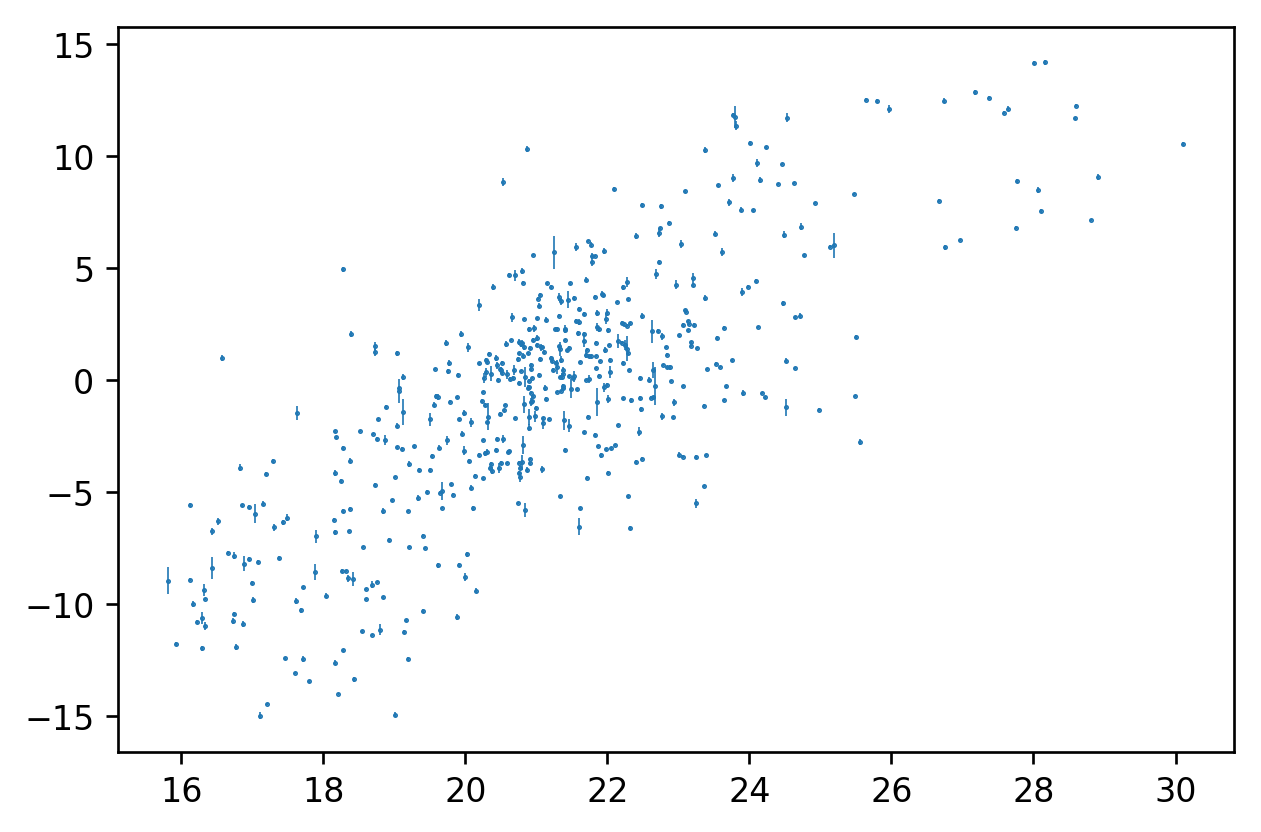

In [49]:
plt.errorbar(
    hy_dr2.parallax,
    (hy_dr2.pmra-hy_dr2.pmra.mean())/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
# plt.axhline(0, c='k')
# plt.axvline(0, c='k');

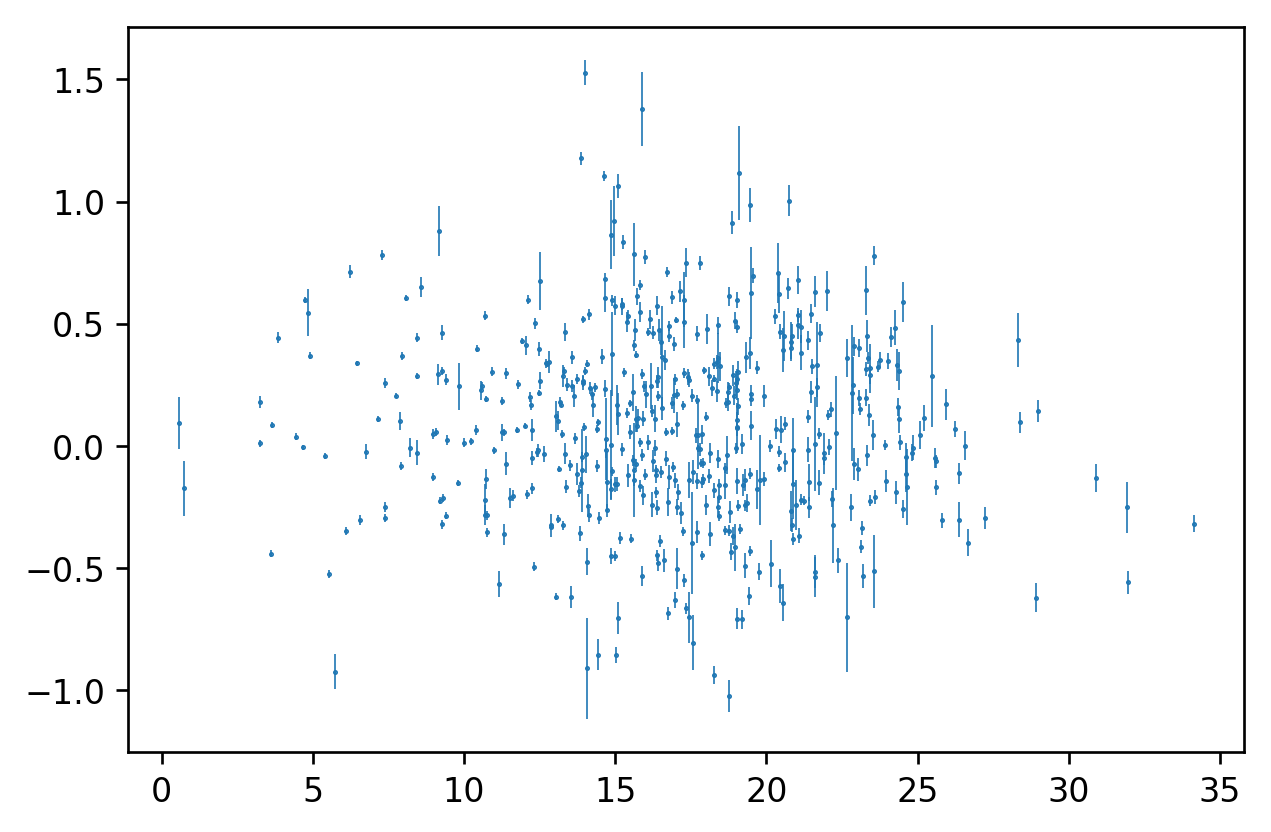

In [46]:
plt.errorbar(
    hy_dr2.dec,
    (hy_dr2.pmdec-hy_dr2_coords_mean.differentials['s'].d_lat.value)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);
# plt.axhline(0, c='k')
# plt.axvline(0, c='k');

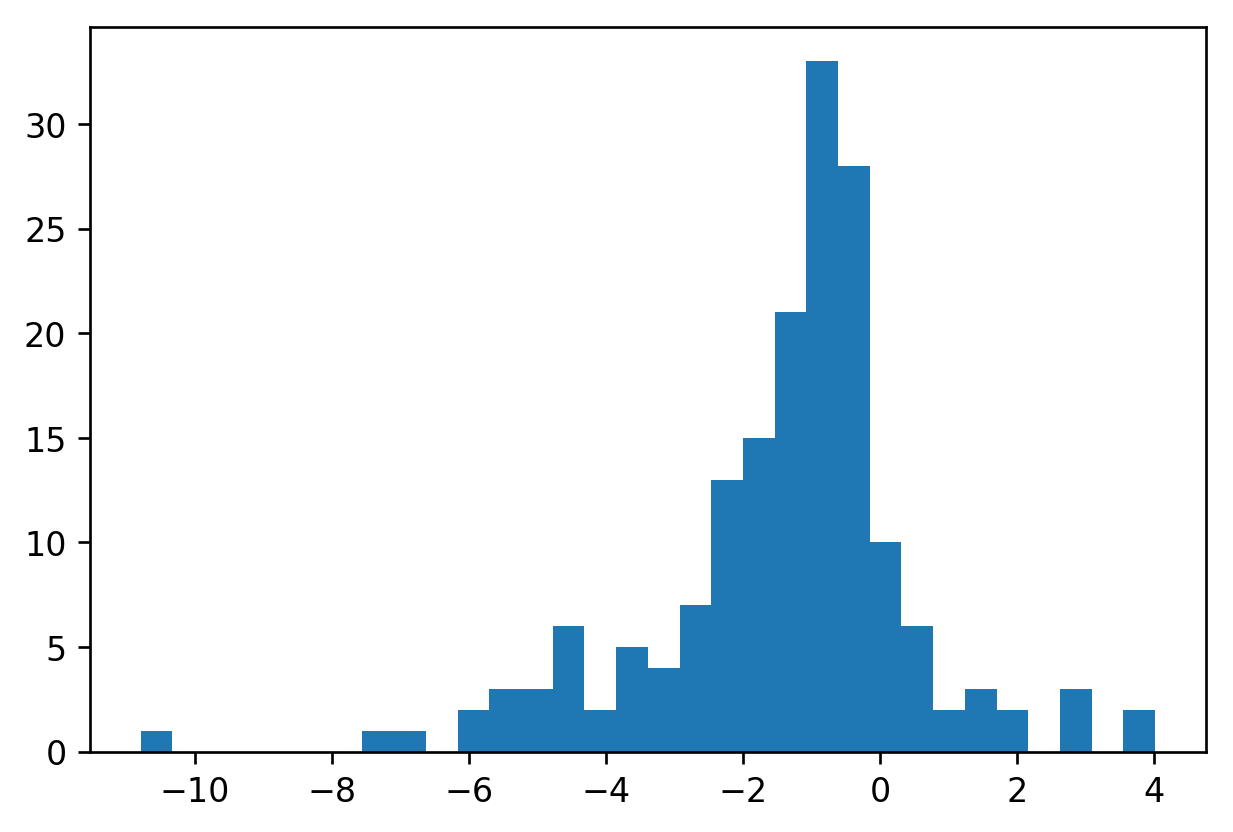

In [149]:
plt.hist((hy_dr2.pmra-hy_dr2_coords_mean.differentials['s'].d_lon.value)/hy_dr2.parallax*4.74, 32);

In [67]:
hy_dr2[['pmra','pmdec']].describe()

,pmra,pmdec
count,515.000000,515.000000
mean,102.742181,-27.098107
std,24.912271,15.682757
min,42.851297,-77.695168
25%,86.651104,-37.888986
50%,103.018496,-27.228486
75%,114.312377,-18.314095
max,187.065993,24.721862


In [125]:
# vmean = [-5.96, 45.60, 5.57] * u.km/u.s   # cartesian equatorial
N = 200
vi = np.random.normal(0, 0.3, size=(N, 3))

cartesian_coords = coord.ICRS(
    hy_dr2_coords.cartesian.xyz,
    v_x=np.random.normal(0, 0.3, size=len(hy_dr2_coords))*u.km/u.s,
    v_y=np.random.normal(0, 0.3, size=len(hy_dr2_coords))*u.km/u.s,
    v_z=np.random.normal(0, 0.3, size=len(hy_dr2_coords))*u.km/u.s,
    representation_type='cartesian',
    differential_type='cartesian')
pmra = cartesian_coords.spherical.differentials['s'].d_lon.to(u.mas/u.yr).value
pmdec = cartesian_coords.spherical.differentials['s'].d_lat.to(u.mas/u.yr).value

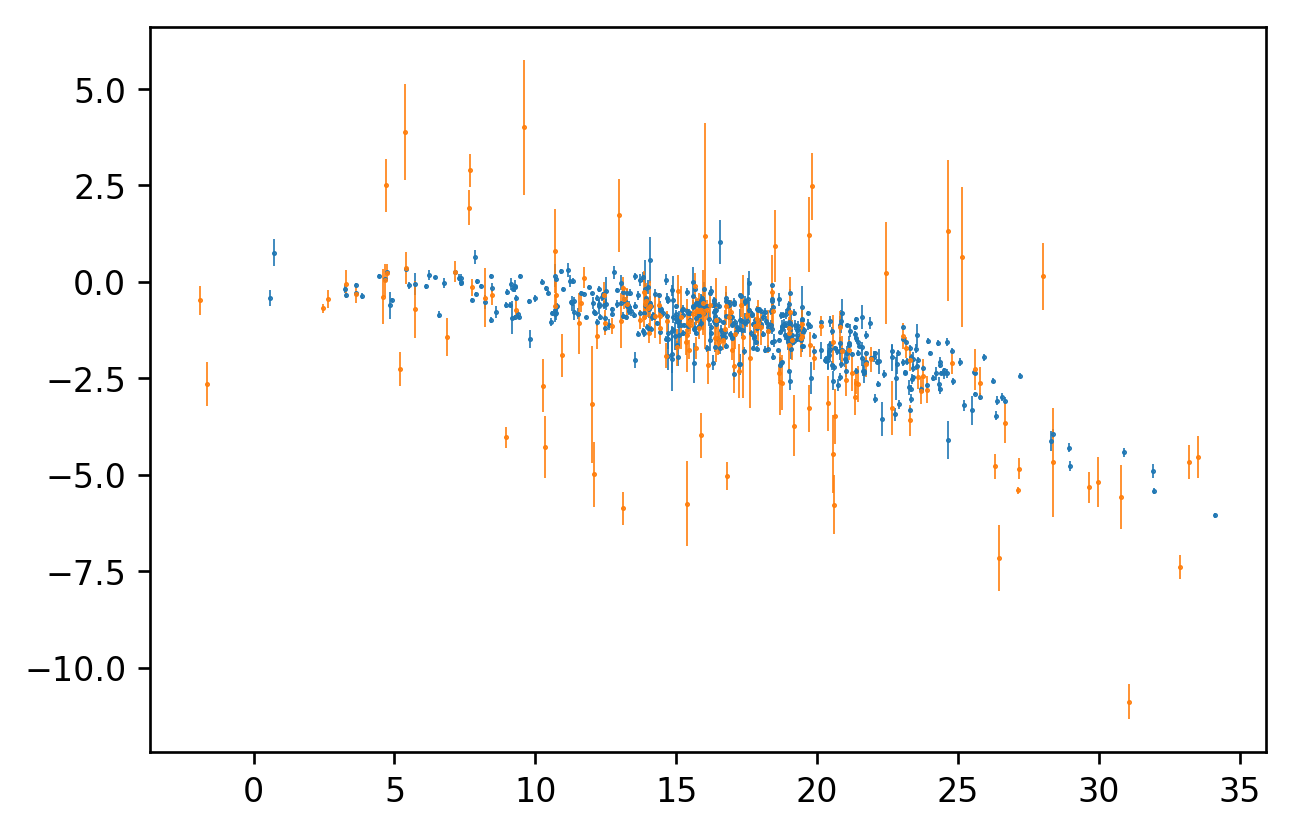

In [269]:

# plt.scatter(cartesian_coords.spherical.lat, pmra, s=1, c='k')

plt.errorbar(
    hy_dr2.dec,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
plt.errorbar(
    hy_tgas.dec,
    (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);

In [268]:
np.cos(np.deg2rad(hy_dr2.ra)).describe(), np.sin(np.deg2rad(hy_dr2.ra)).describe()

(count    515.000000
 mean       0.377893
 std        0.088009
 min        0.099914
 25%        0.318133
 50%        0.383532
 75%        0.428004
 max        0.634289
 Name: ra, dtype: float64, count    515.000000
 mean       0.920910
 std        0.037344
 min        0.773096
 25%        0.903777
 50%        0.923527
 75%        0.948046
 max        0.994996
 Name: ra, dtype: float64)

In [136]:
from corner import corner

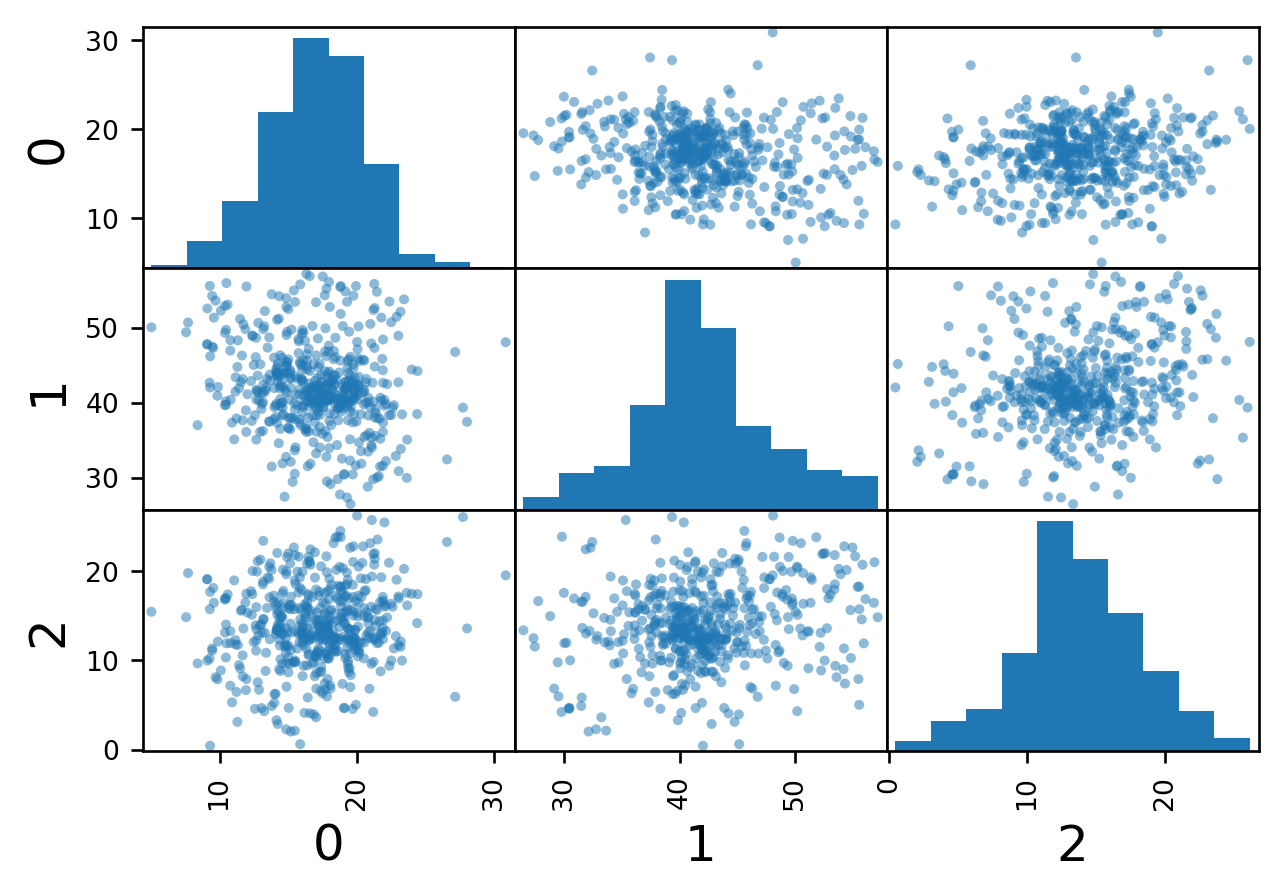

In [144]:
pd.plotting.scatter_matrix(pd.DataFrame(hy_dr2_coords.cartesian.xyz.value.T));

In [145]:
import seaborn as sns

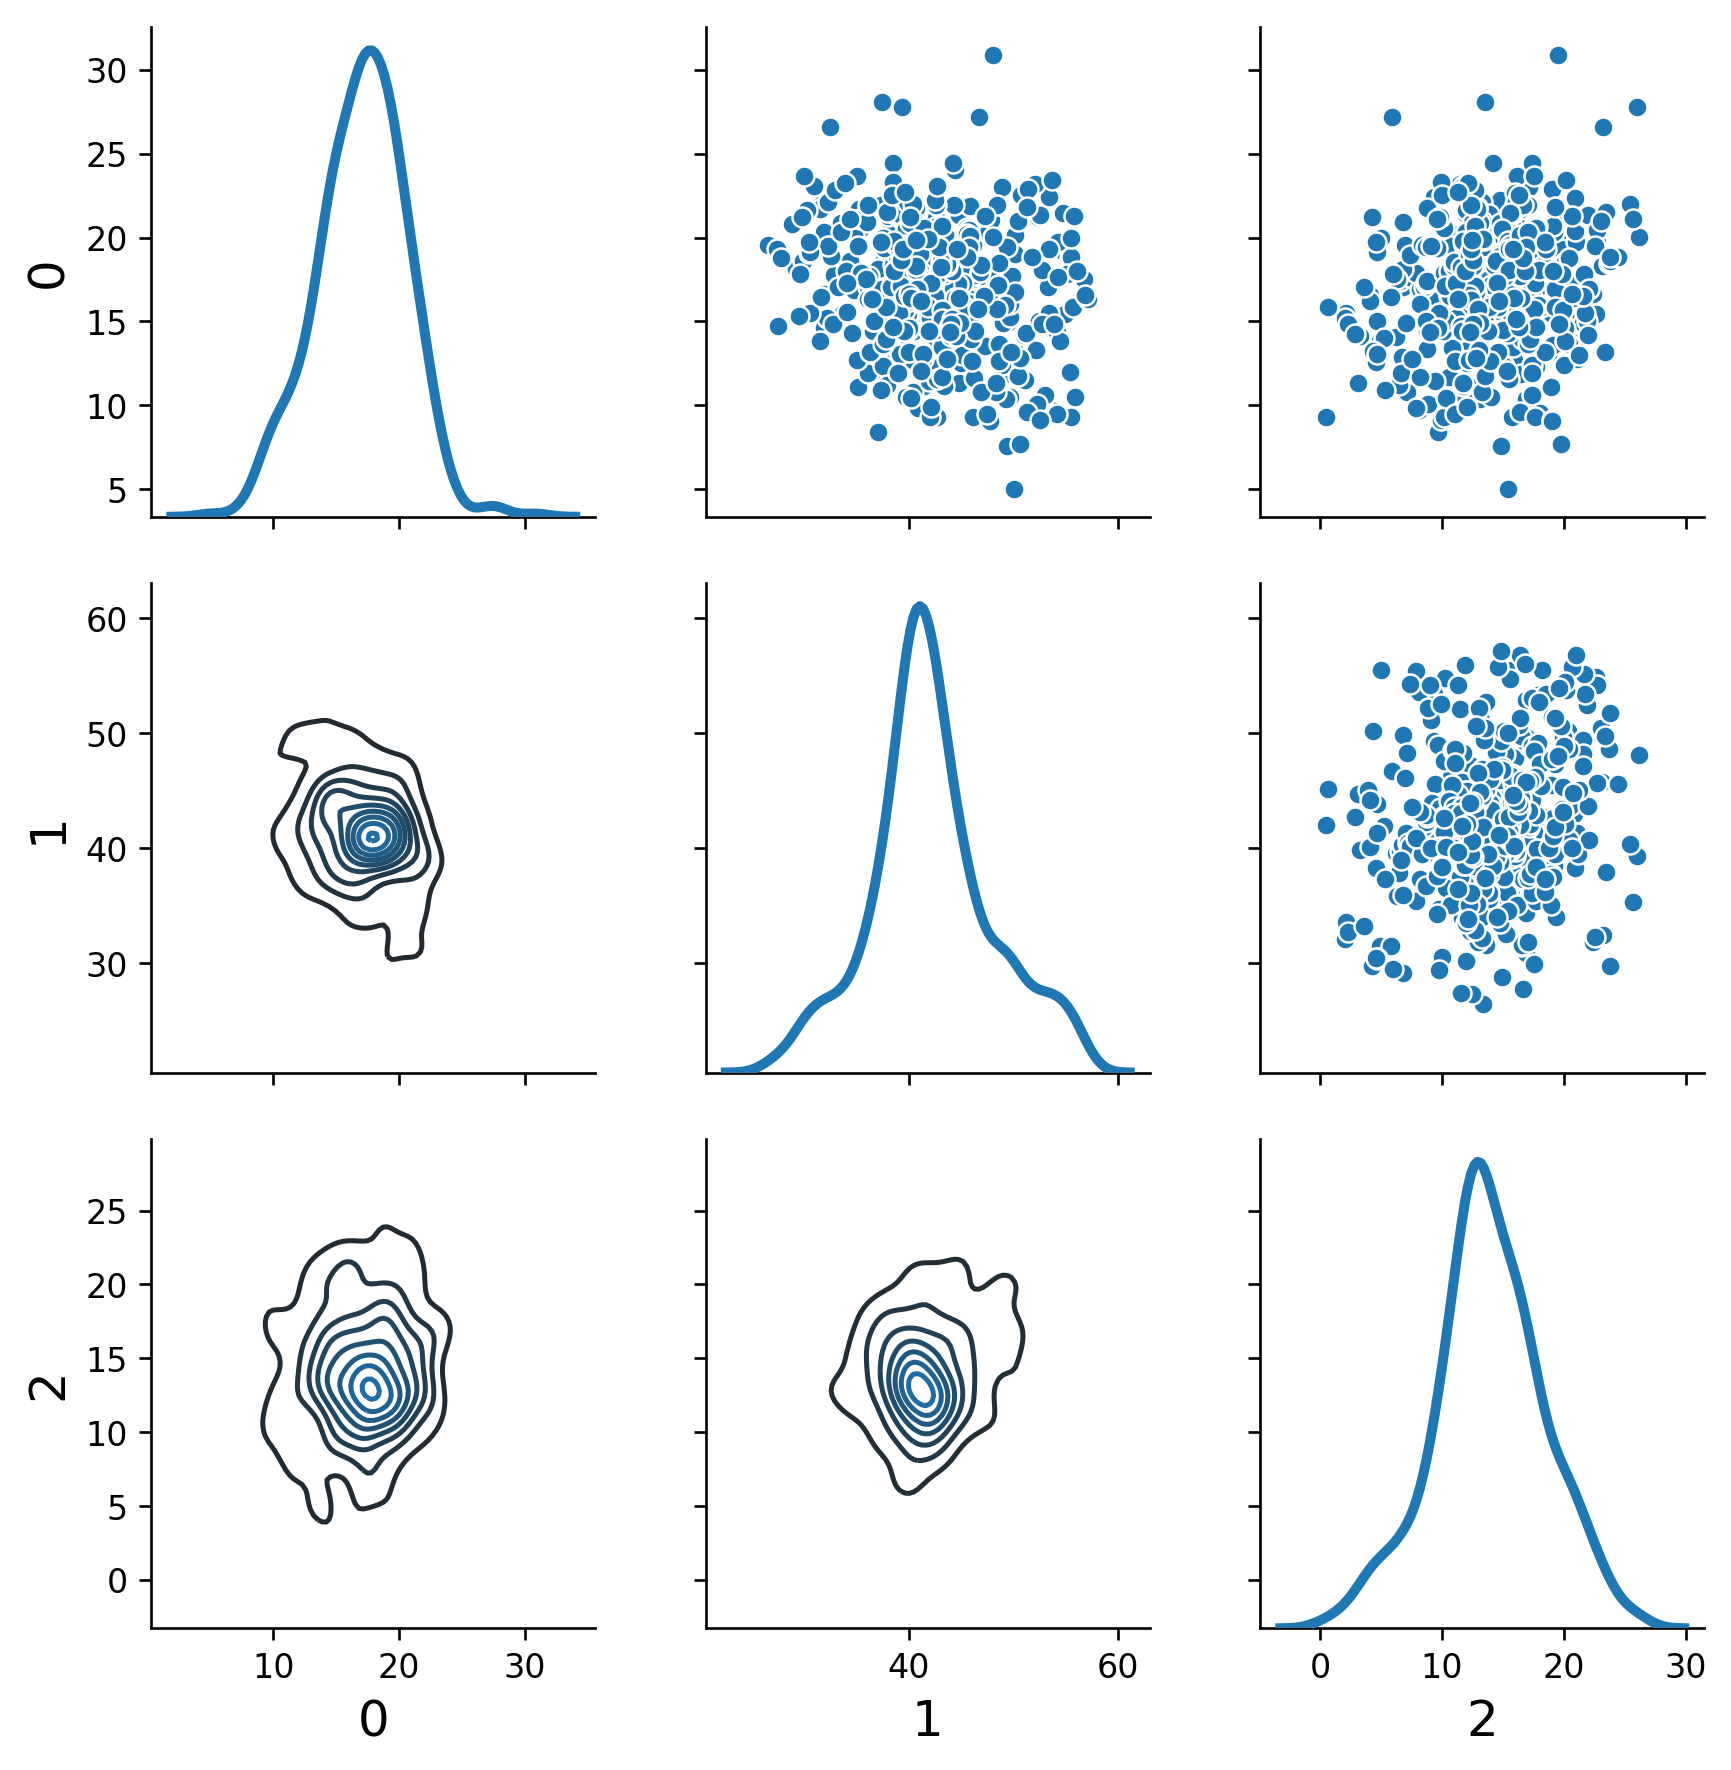

In [146]:

g = sns.PairGrid(pd.DataFrame(hy_dr2_coords.cartesian.xyz.value.T), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3);

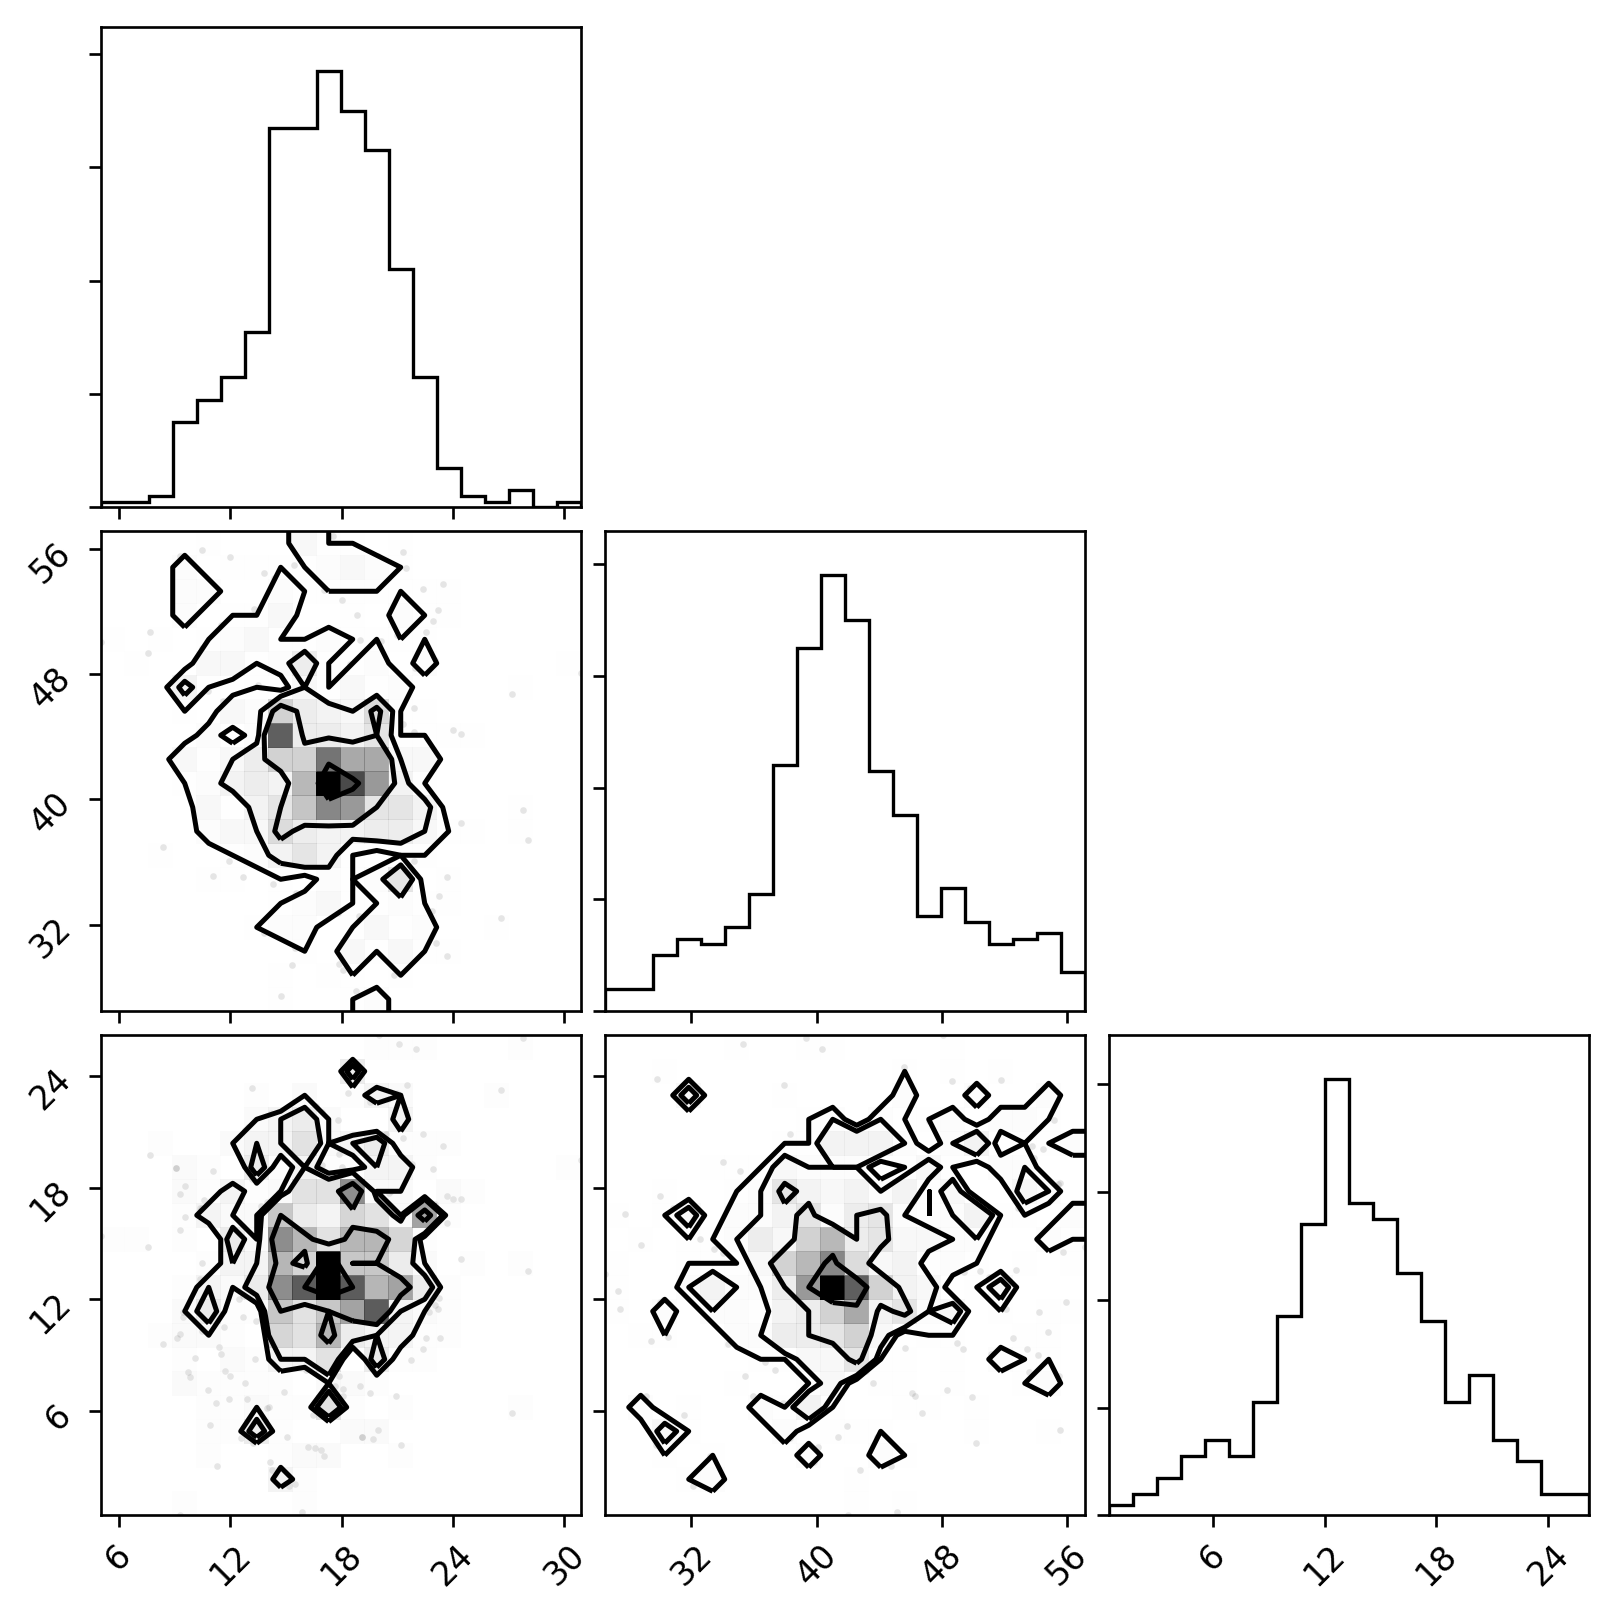

In [137]:
corner(hy_dr2_coords.cartesian.xyz.value.T);